# AIPI 590 - XAI | Explainable Techniques II
### Exploratory analysis of a dataset to determine the amount of correlation between features
### Mariam Khan

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Mkhan13/XAI/blob/main/explainable_techniques_II.ipynb)

In [ ]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
from alepython import ale_plot

In [ ]:
repo_name = "XAI"
branch_name = "explainable_ml"
git_path = "https://github.com/Mkhan13/XAI.git"

# If repo already exists, remove it first to avoid conflicts
if os.path.exists(repo_name):
    !rm -rf {repo_name}

# Clone the branch
!git clone -b {branch_name} {git_path}

# Path to data folder
data_dir = os.path.join(repo_name, "data", "explainable_ml_II")

# Verify files exist
print("Files in data folder:", os.listdir(data_dir))

In [ ]:
# Load CSV
zoo_path = os.path.join(data_dir, "zoo.csv")
class_path = os.path.join(data_dir, "class.csv")

zoo_df = pd.read_csv(zoo_path)
class_df = pd.read_csv(class_path)

# Merge on class_type
zoo_df = zoo_df.merge(class_df, how="left", left_on="class_type", right_on="Class_Number")

# Drop the redundant numeric columns
zoo_df = zoo_df.drop(columns=["class_type", "Number_Of_Animal_Species_In_Class", "Animal_Names"])

# Rename for clarity
zoo_df = zoo_df.rename(columns={"Class_Type": "class_type", "Class_Number": "class_number"})

# Show dataset
print(zoo_df.head())

  animal_name  hair  feathers  eggs  milk  airborne  aquatic  predator  \
0    aardvark     1         0     0     1         0        0         1   
1    antelope     1         0     0     1         0        0         0   
2        bass     0         0     1     0         0        1         1   
3        bear     1         0     0     1         0        0         1   
4        boar     1         0     0     1         0        0         1   

   toothed  backbone  breathes  venomous  fins  legs  tail  domestic  catsize  \
0        1         1         1         0     0     4     0         0        1   
1        1         1         1         0     0     4     1         0        1   
2        1         1         0         0     1     0     1         0        0   
3        1         1         1         0     0     4     0         0        1   
4        1         1         1         0     0     4     1         0        1   

   class_number class_type  
0             1     Mammal  
1         

### RandomForest Model

In [ ]:
# Prepare features and target
X = zoo_df.drop(columns=["animal_name", "class_type", "class_number"])  # want to train on numeric columns only
y = zoo_df["class_number"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # Stratify to avoid class imbalance

In [ ]:
# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# extract features and classes
feature_names = X.columns.tolist()
class_labels = model.classes_

 # Mapping from class_number to class_type
class_mapping = zoo_df.drop_duplicates("class_number").set_index("class_number")["class_type"].to_dict()

### **PDP Plot**

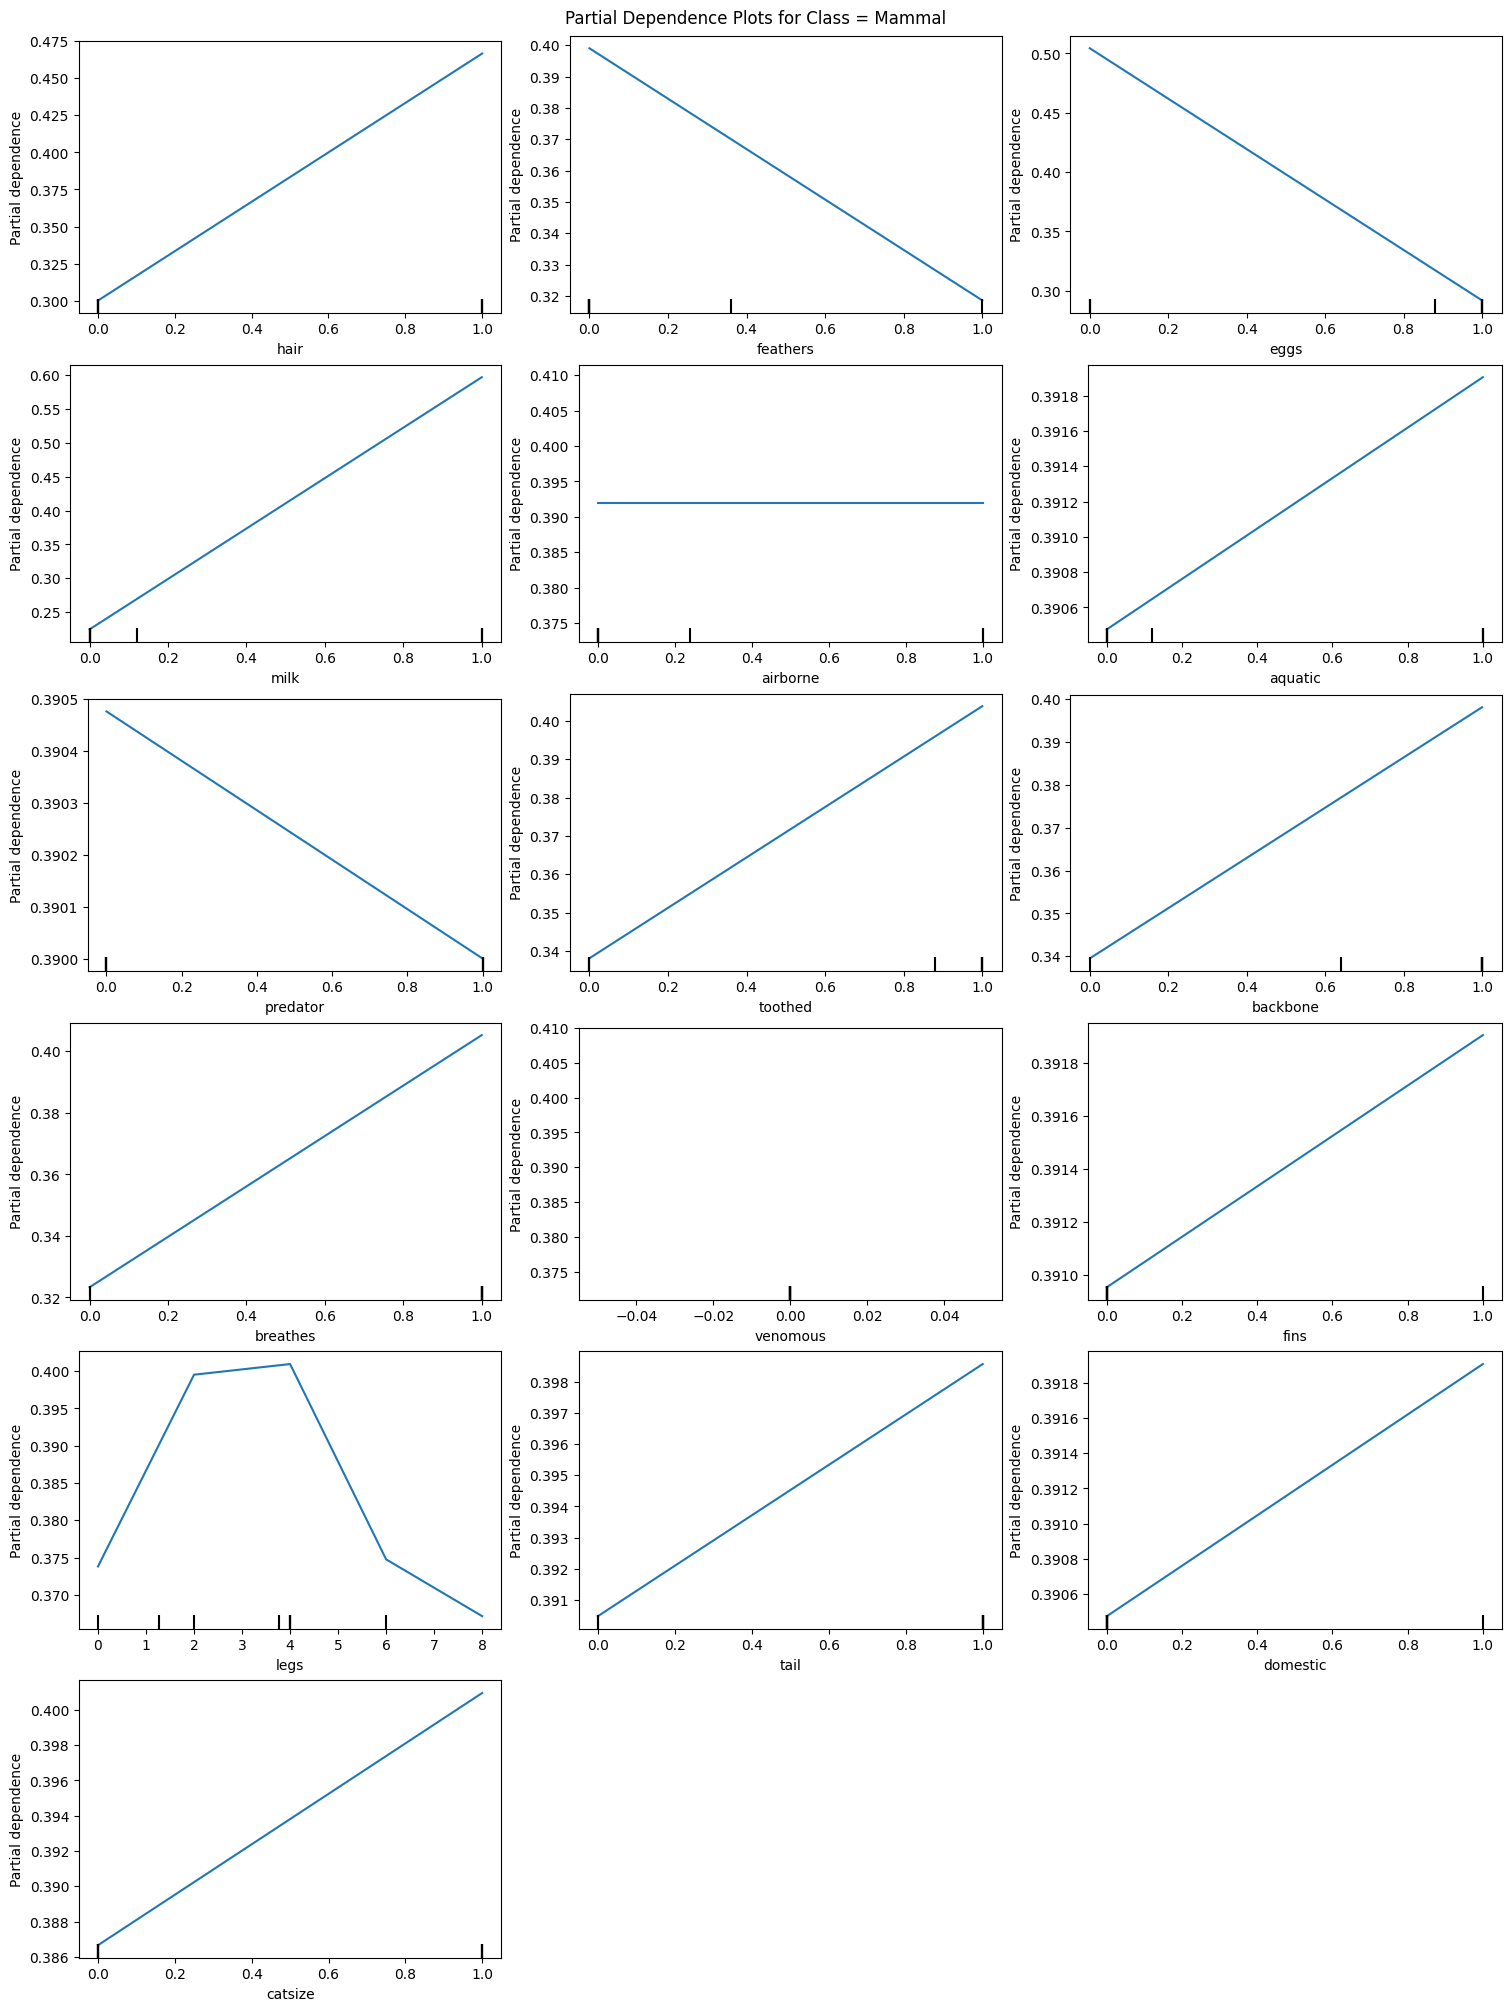

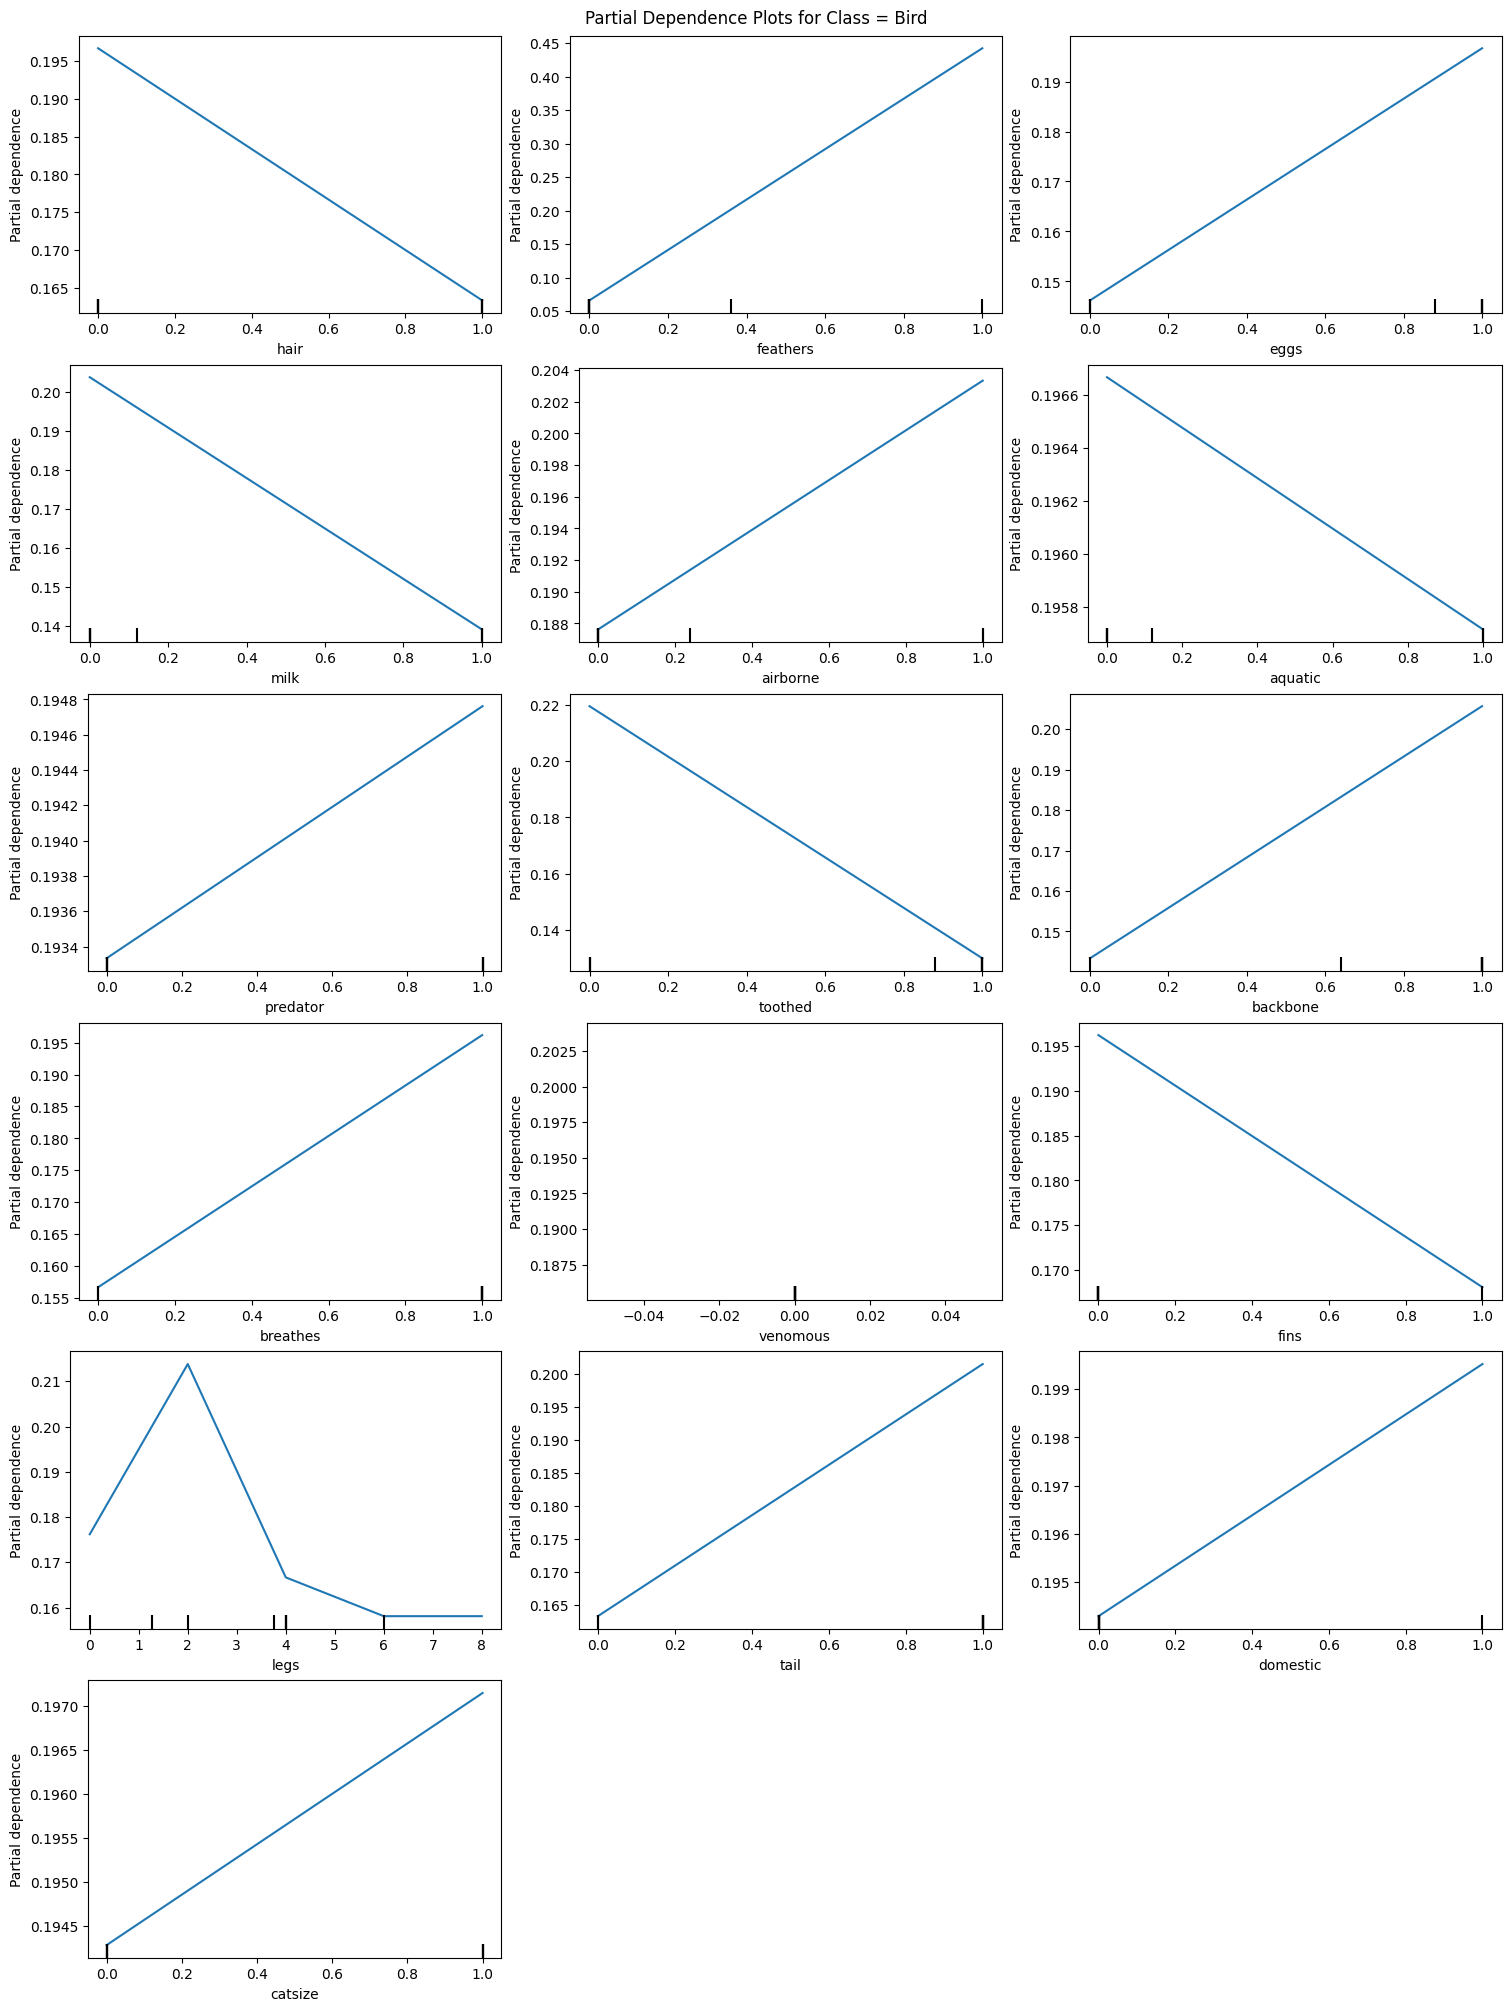

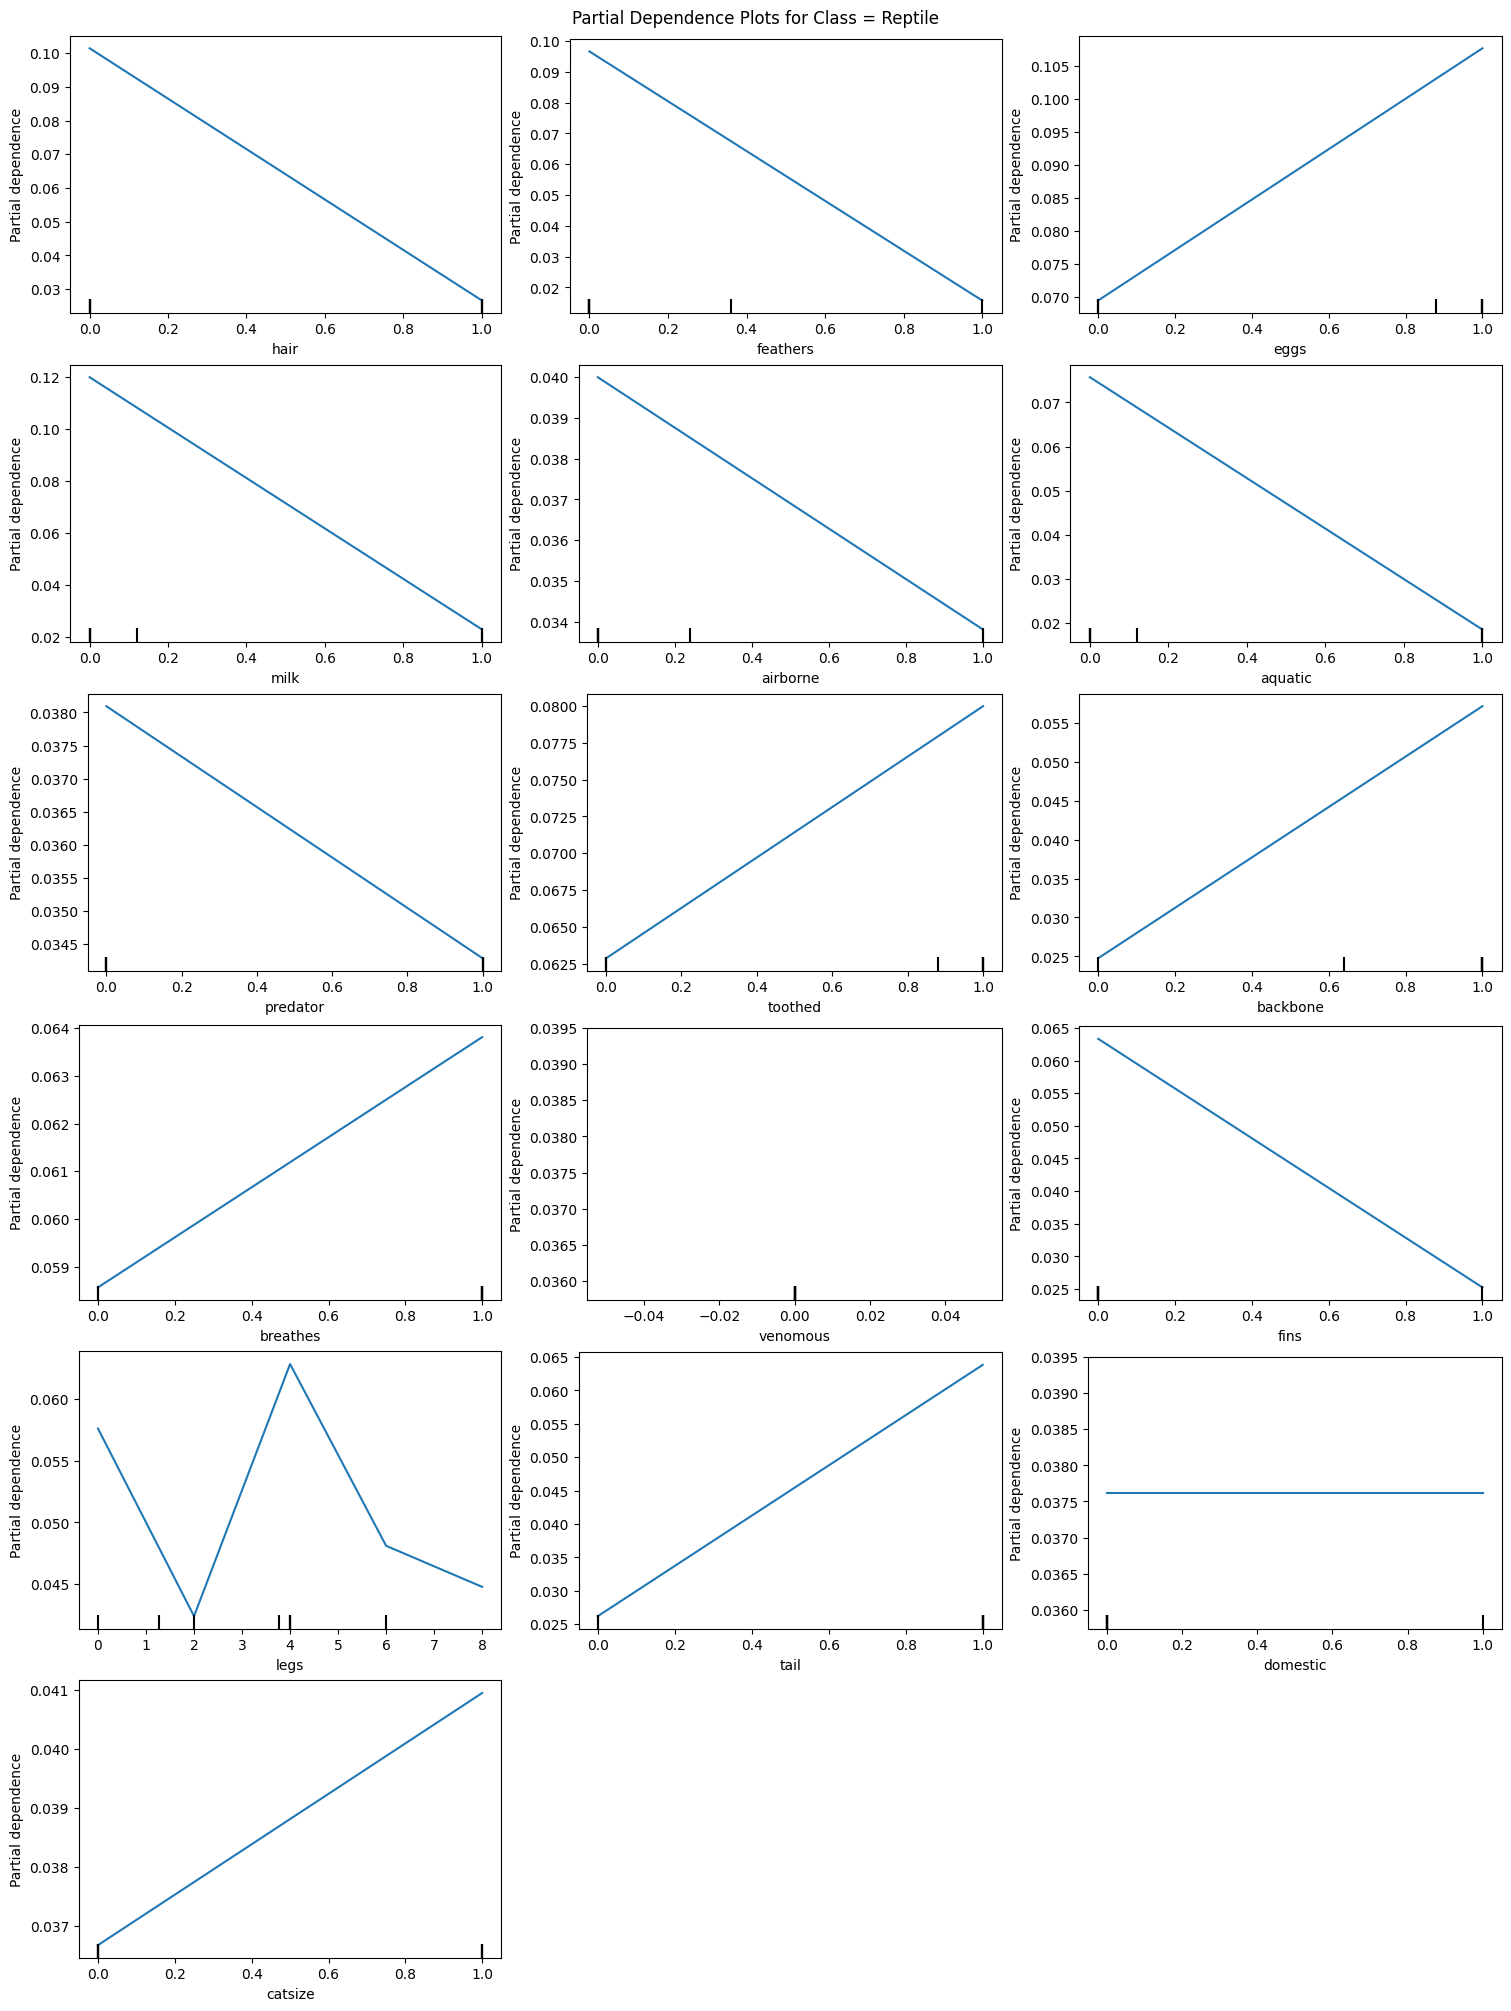

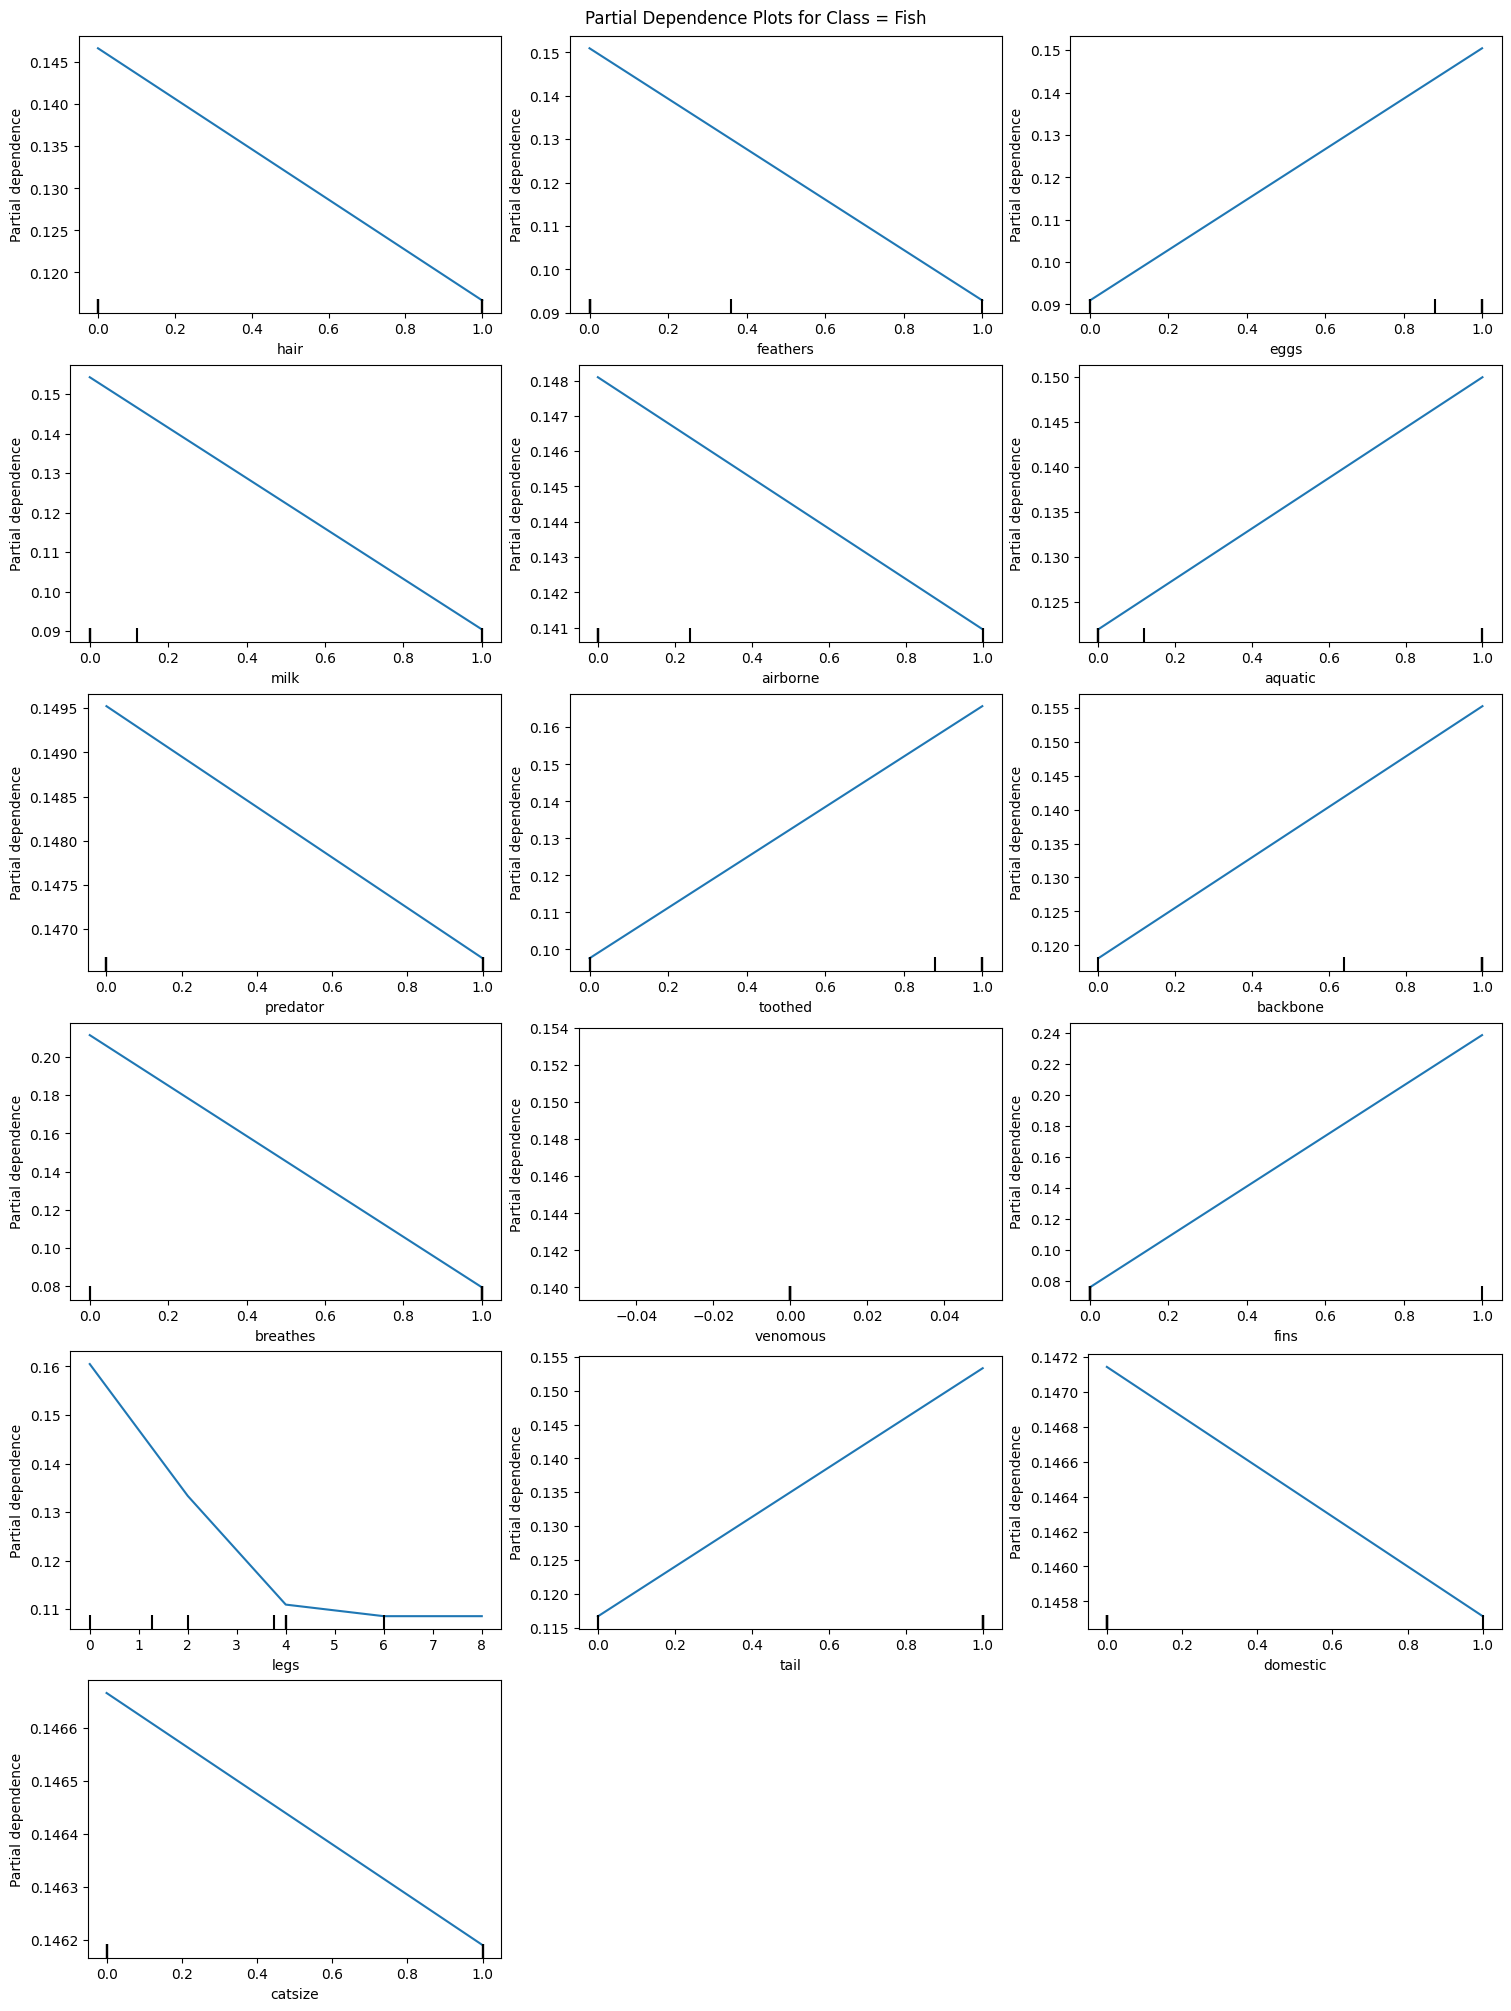

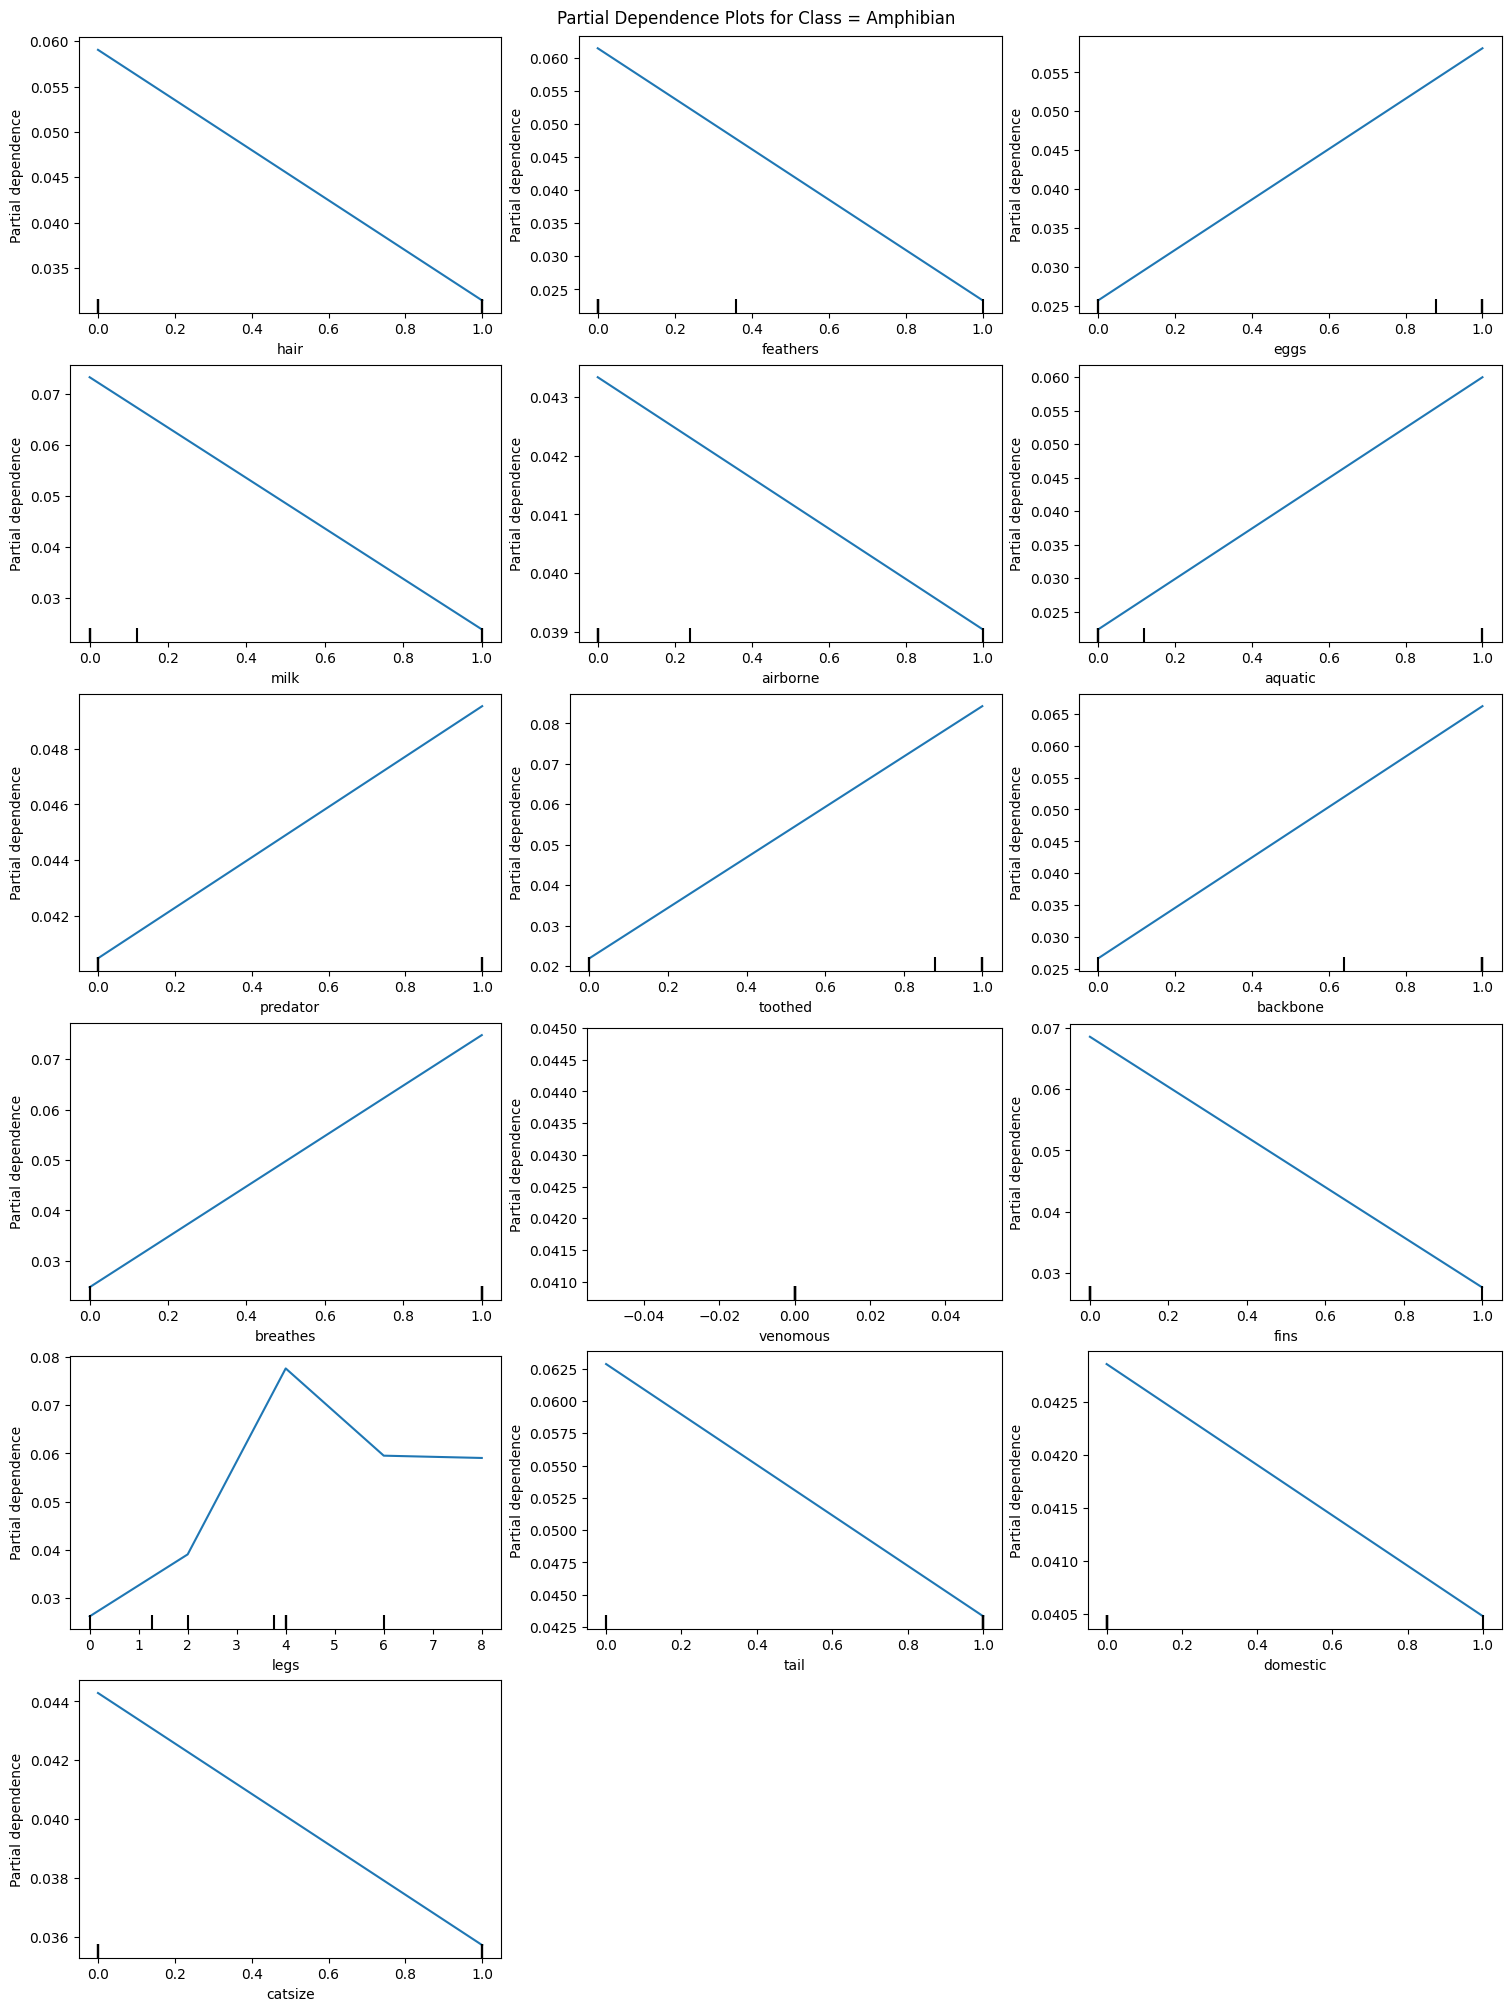

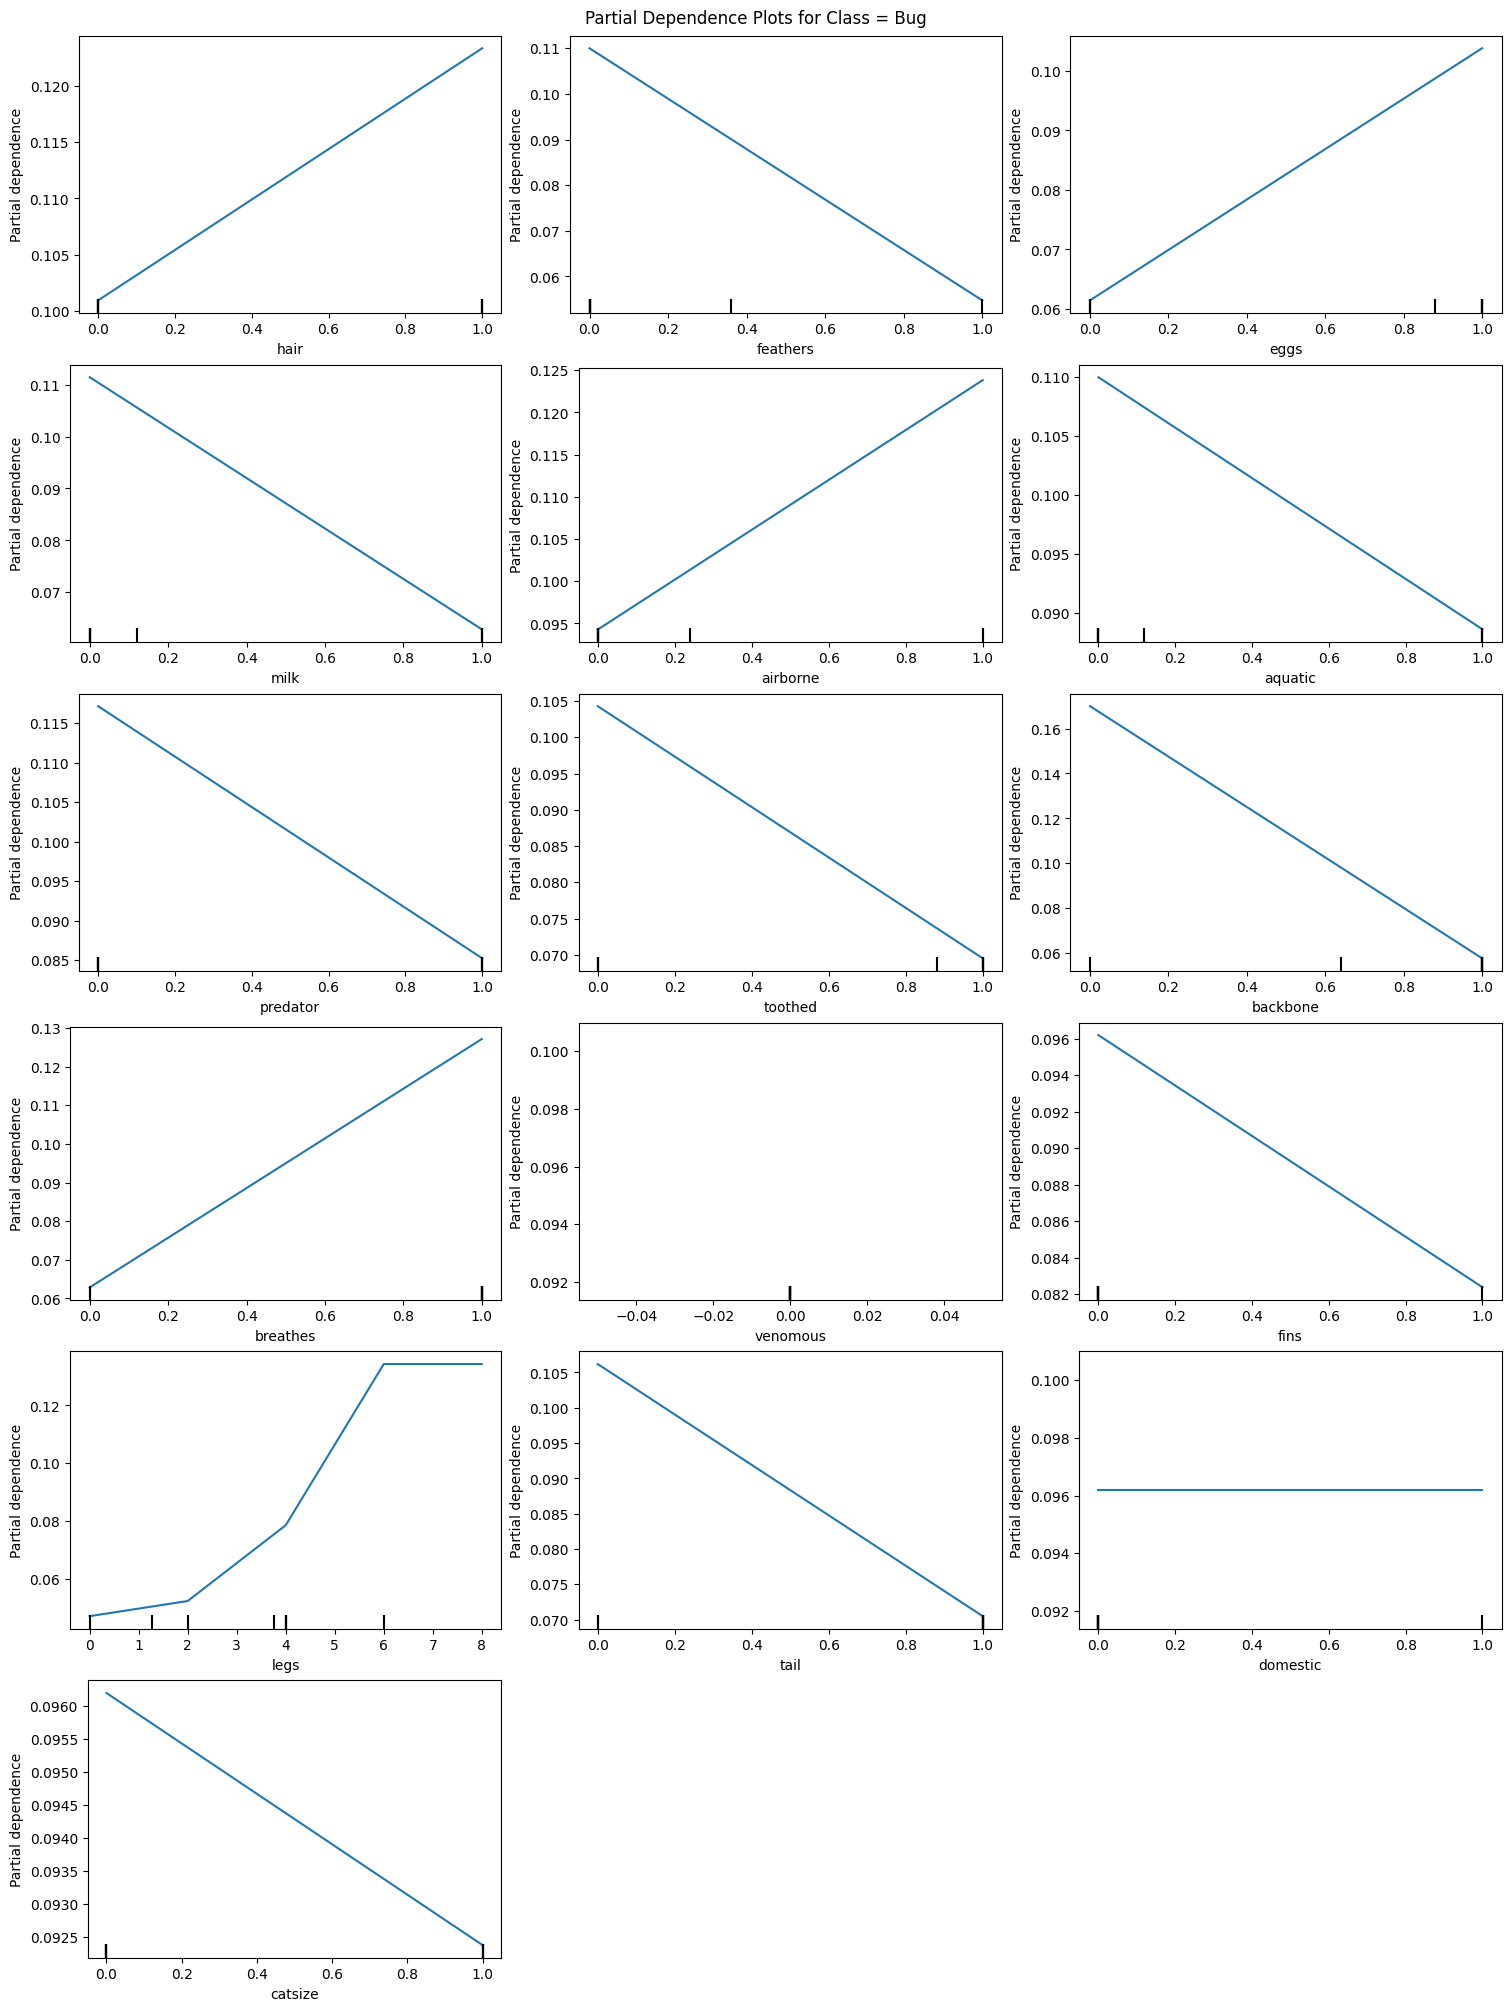

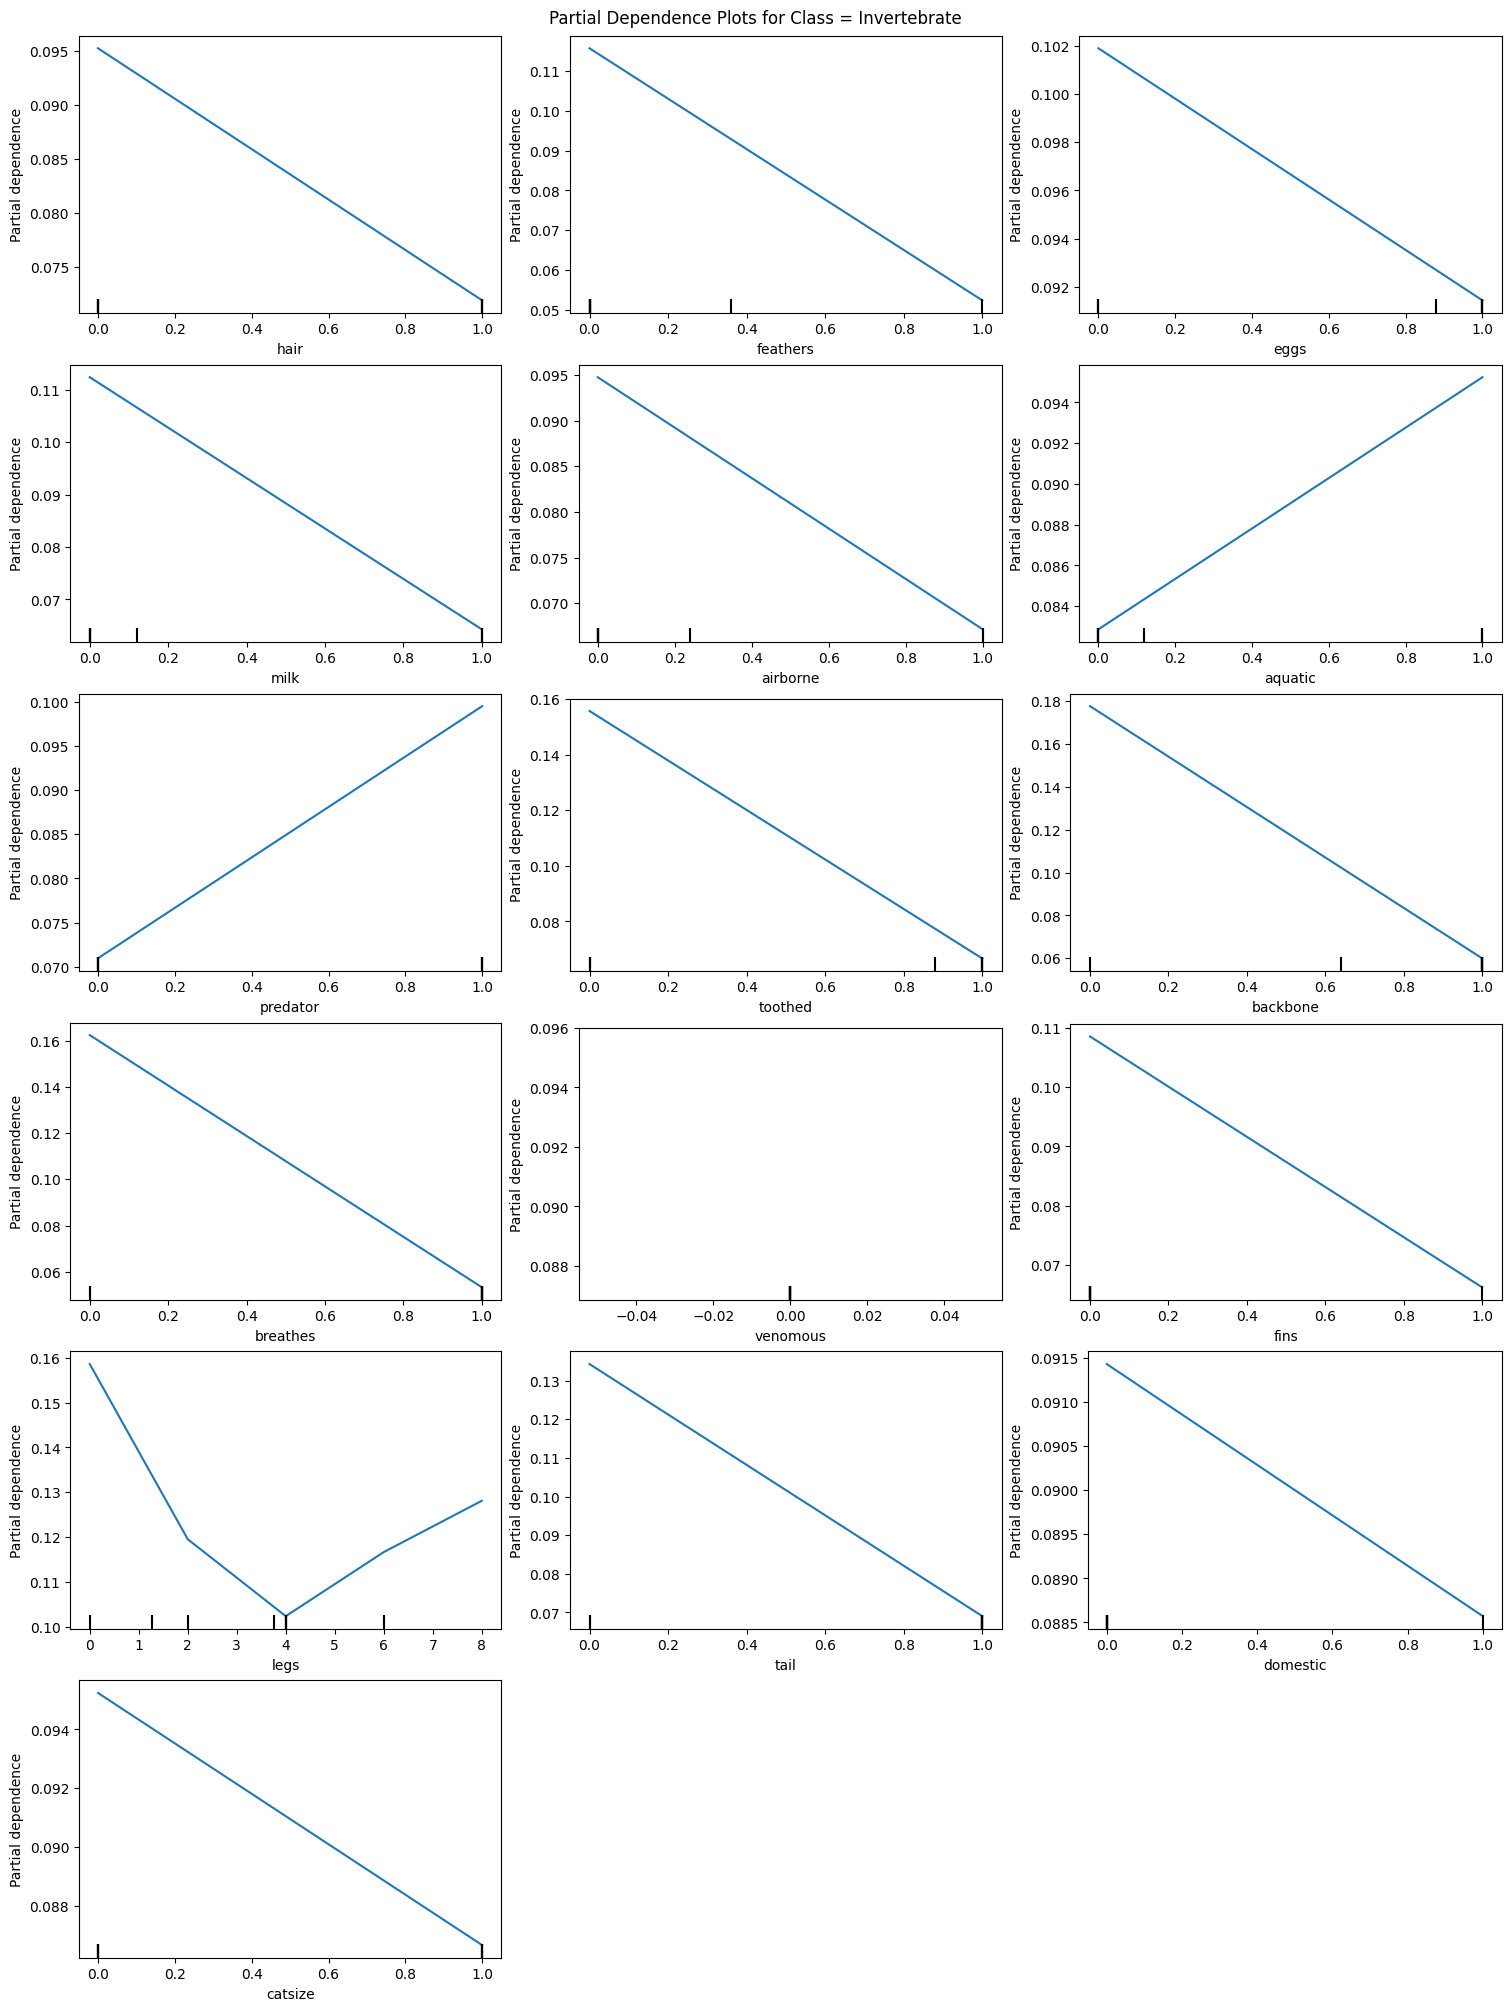

In [33]:
# Create PDP plots for each feature against each class
for target_class in class_labels:
    fig, axes = plt.subplots(nrows=int(len(feature_names) / 3) + 1, ncols=3, figsize=(15, 20), constrained_layout=True)
    axes = axes.flatten()

    for i, feature in enumerate(feature_names):
        PartialDependenceDisplay.from_estimator(model, X_test, [feature], kind="average", target=target_class, ax=axes[i]) # Create PDP plot

    for j in range(len(feature_names), len(axes)): # Hide unused axes
        fig.delaxes(axes[j])

    fig.suptitle(f"Partial Dependence Plots for Class = {class_mapping[target_class]}")
    plt.show()

Based on these PDP plots, there are several strong correlations between the features and classes in the dataset. There is a clear inverse relationship between hair and feathers which makes logical sense: animals that have hair don't have feathers and animals with feathers don't have hair. The same inverse relationship exists between producing milk and laying eggs. The plots also show positive correlations between features, like animals that are predators typically also have teeth.

These relationships between features helps the model better separate the classes. For example, if the animal has hair and produces milk, it is very likely to be a mammal. However, this can also be a concern if the model assigns too much weight to these features and not the others which could reduce the importance of other potentially important discriminative features.

### **ICE Plot**

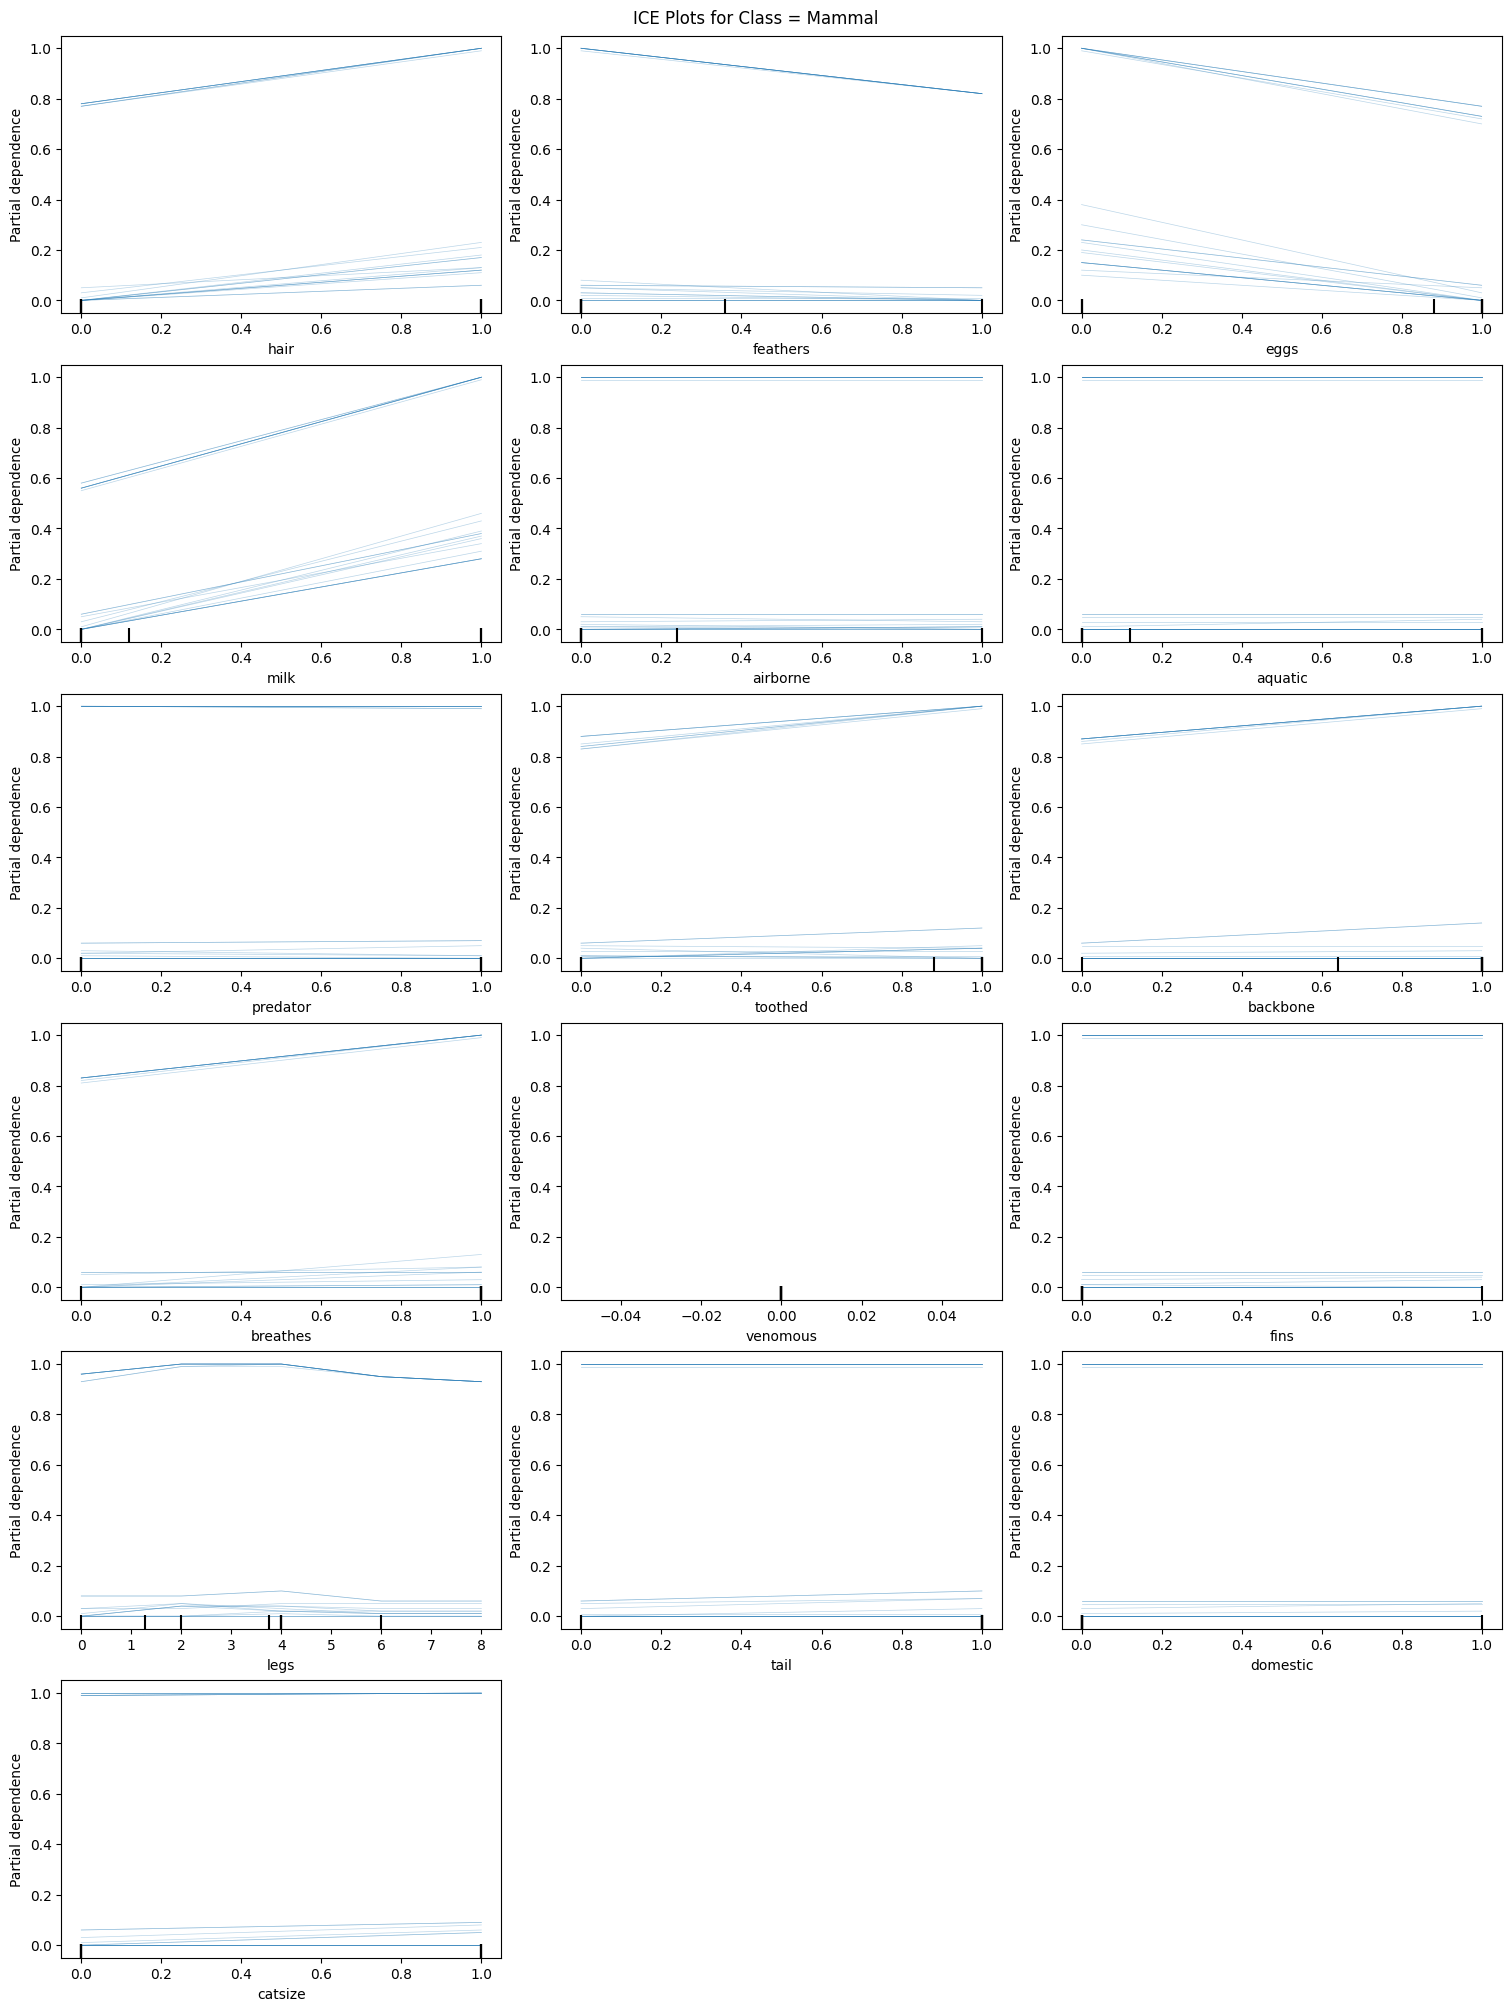

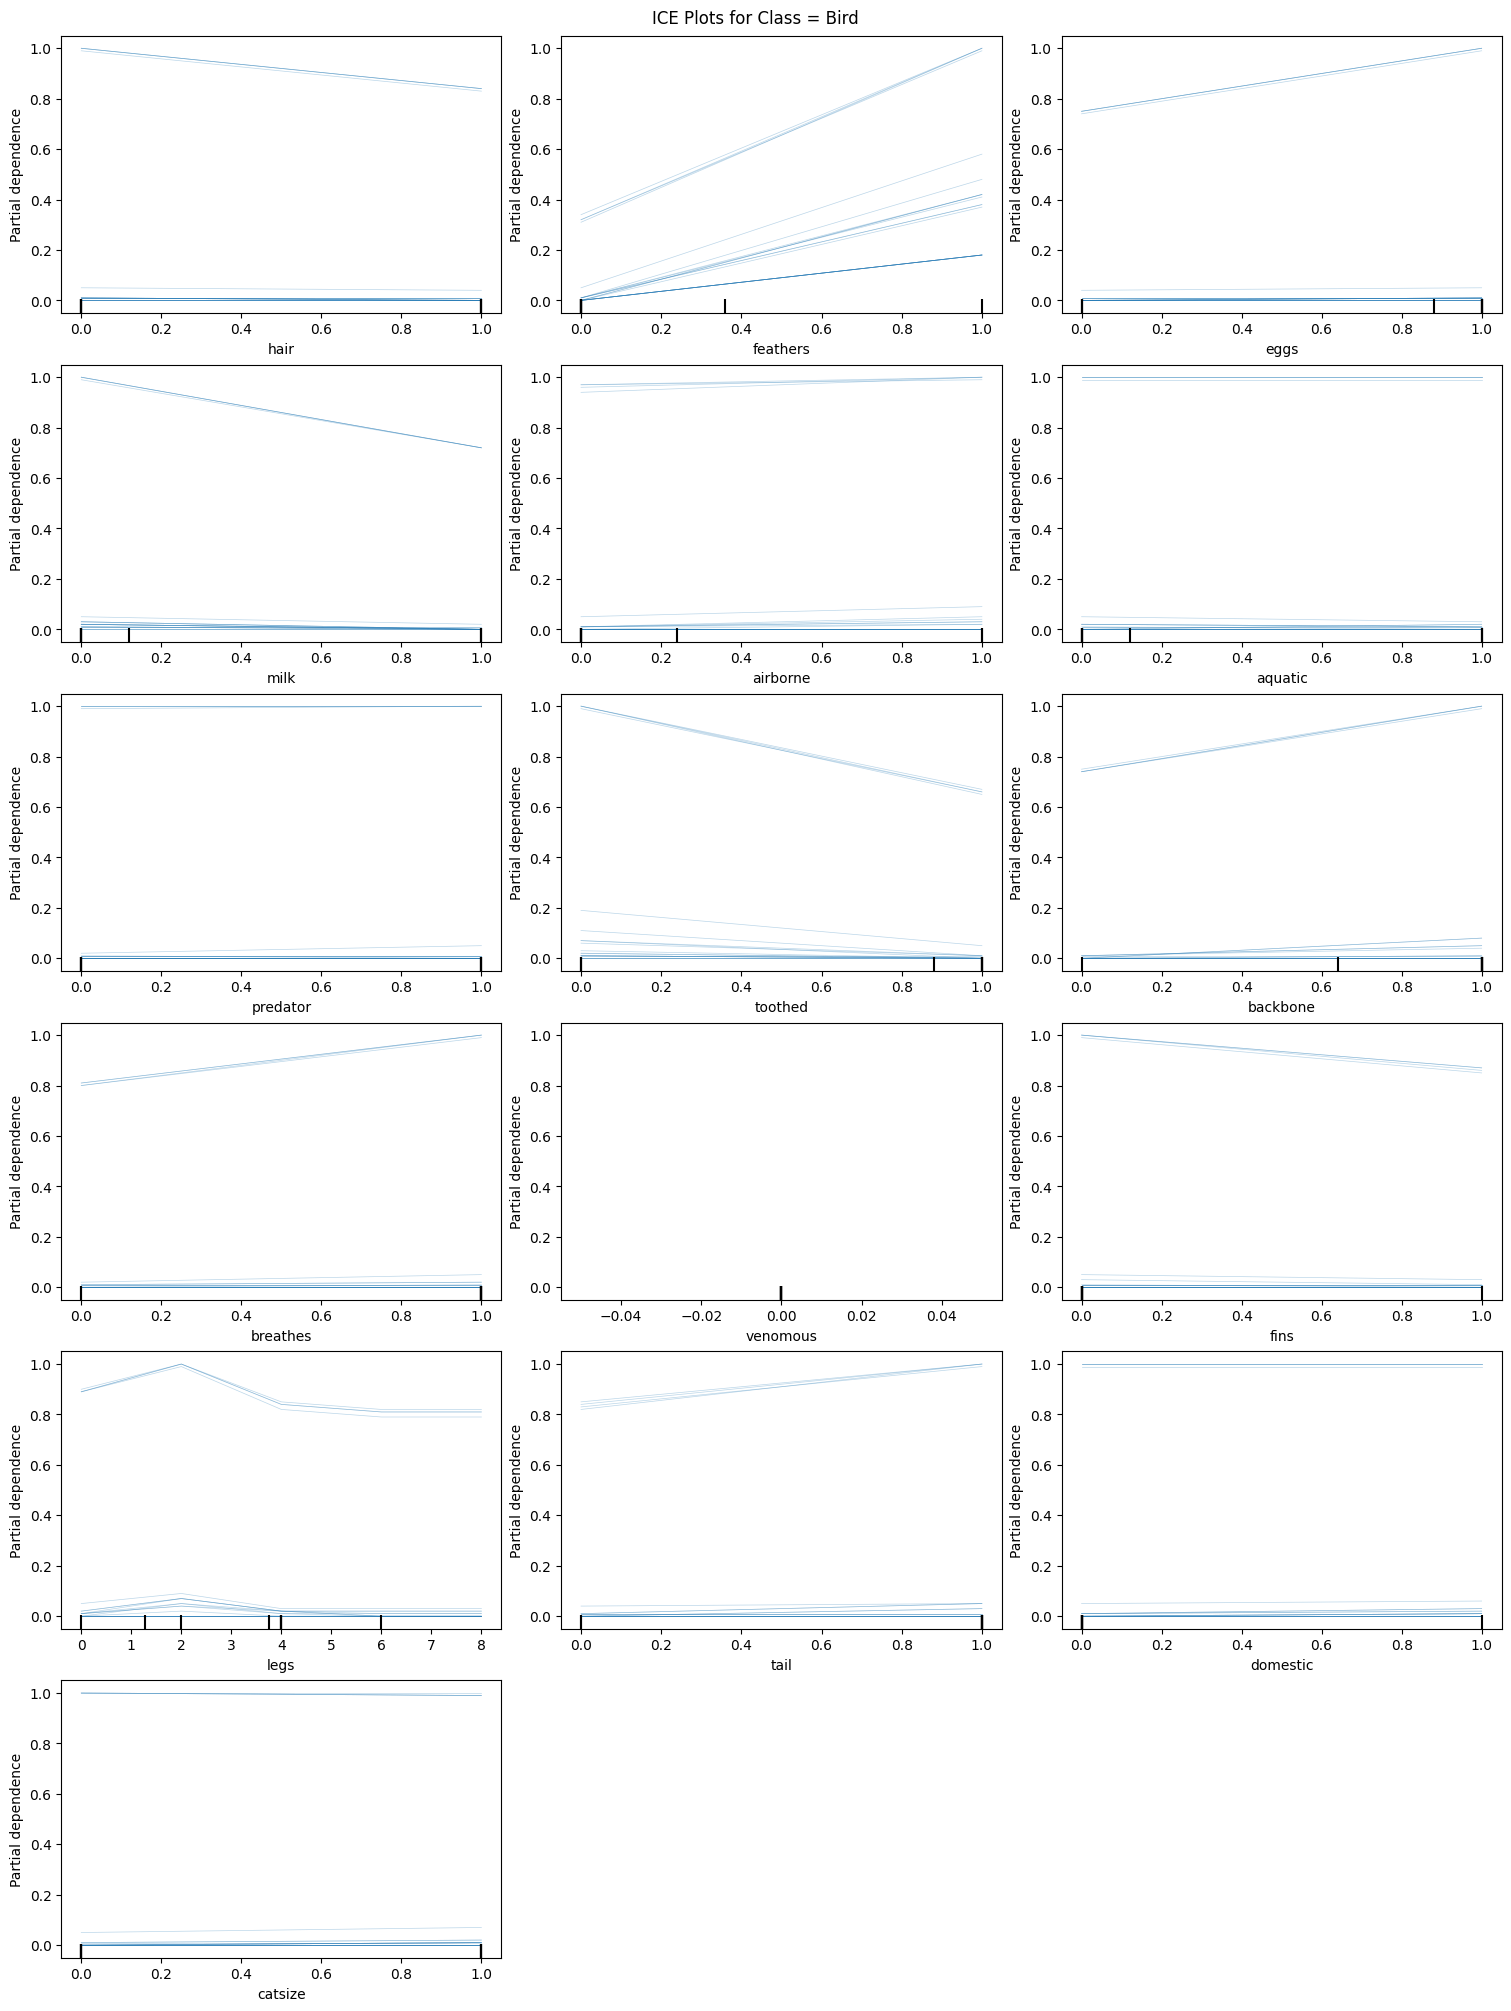

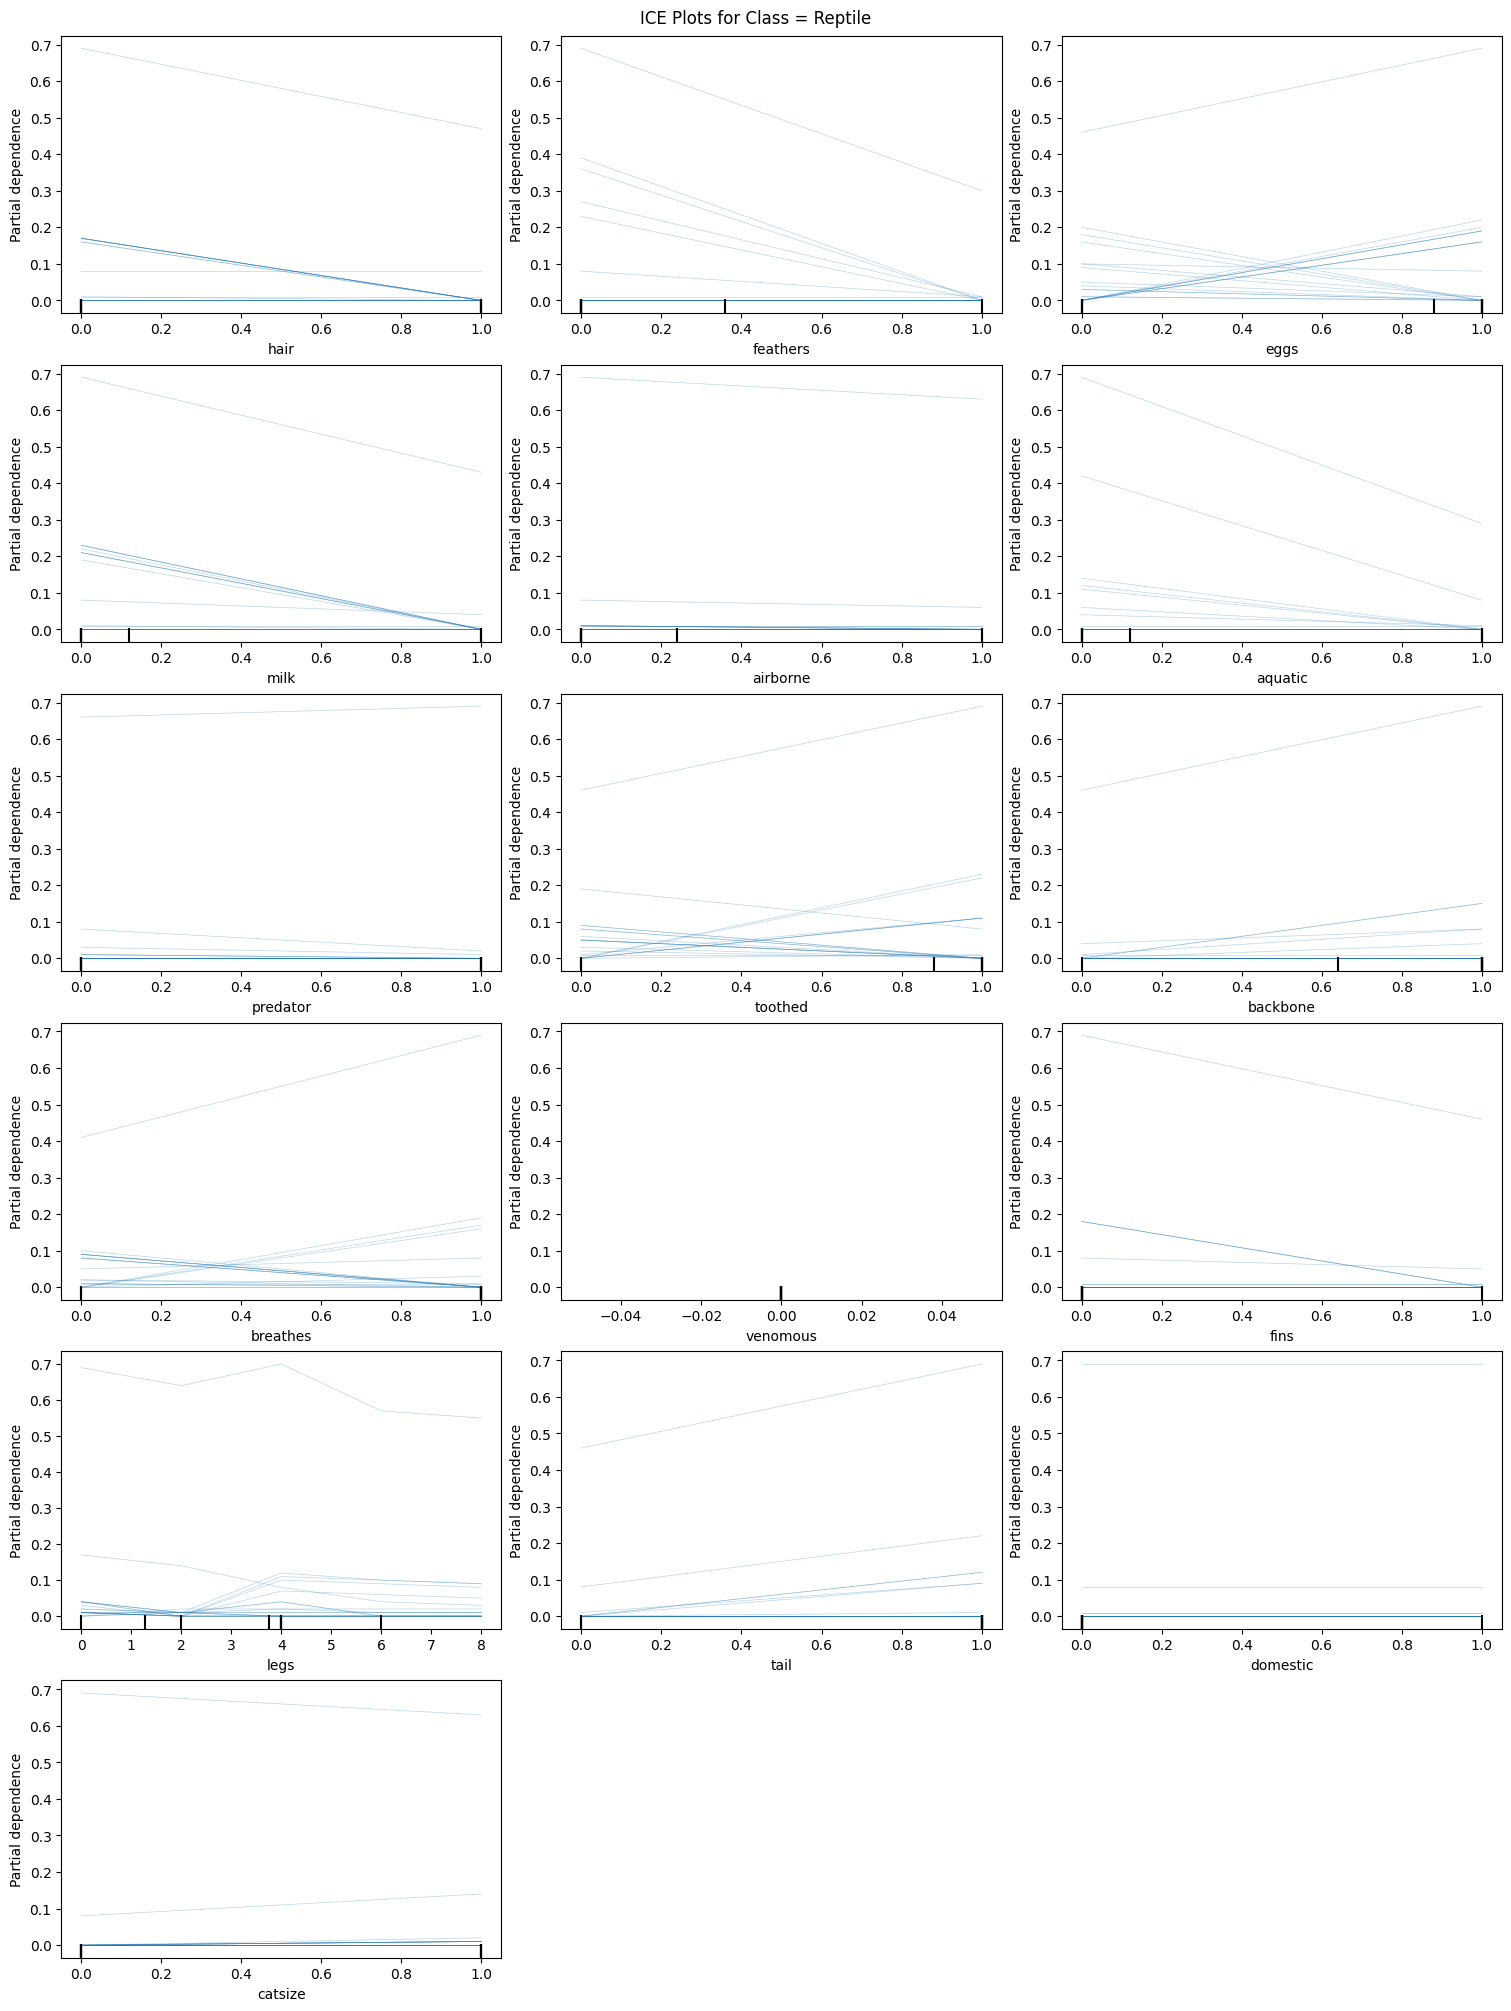

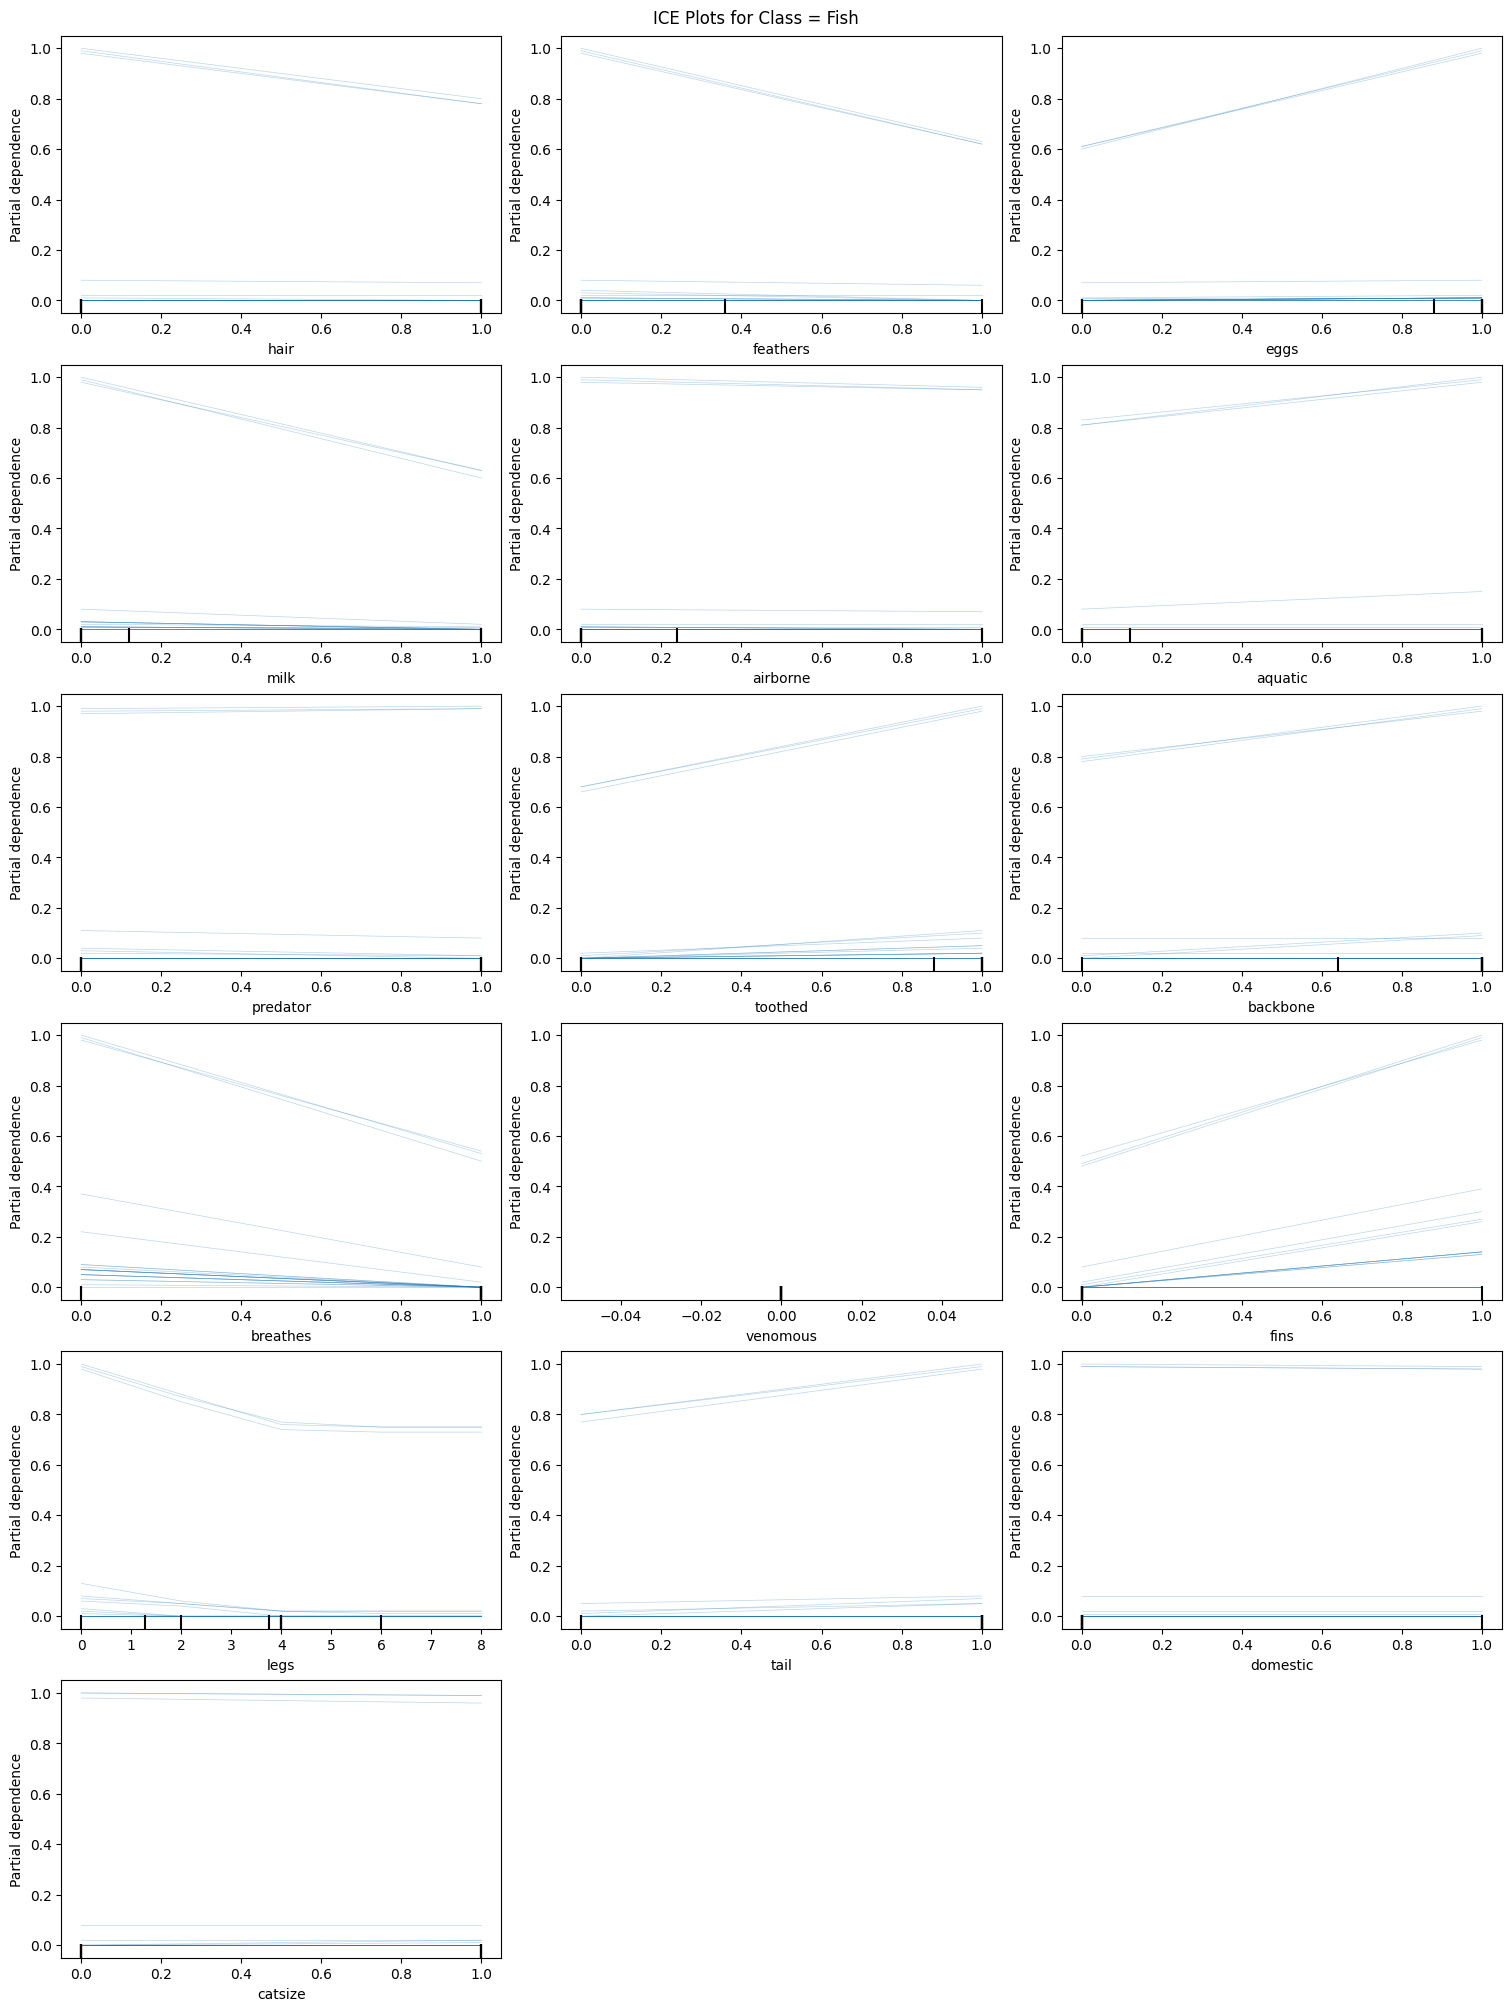

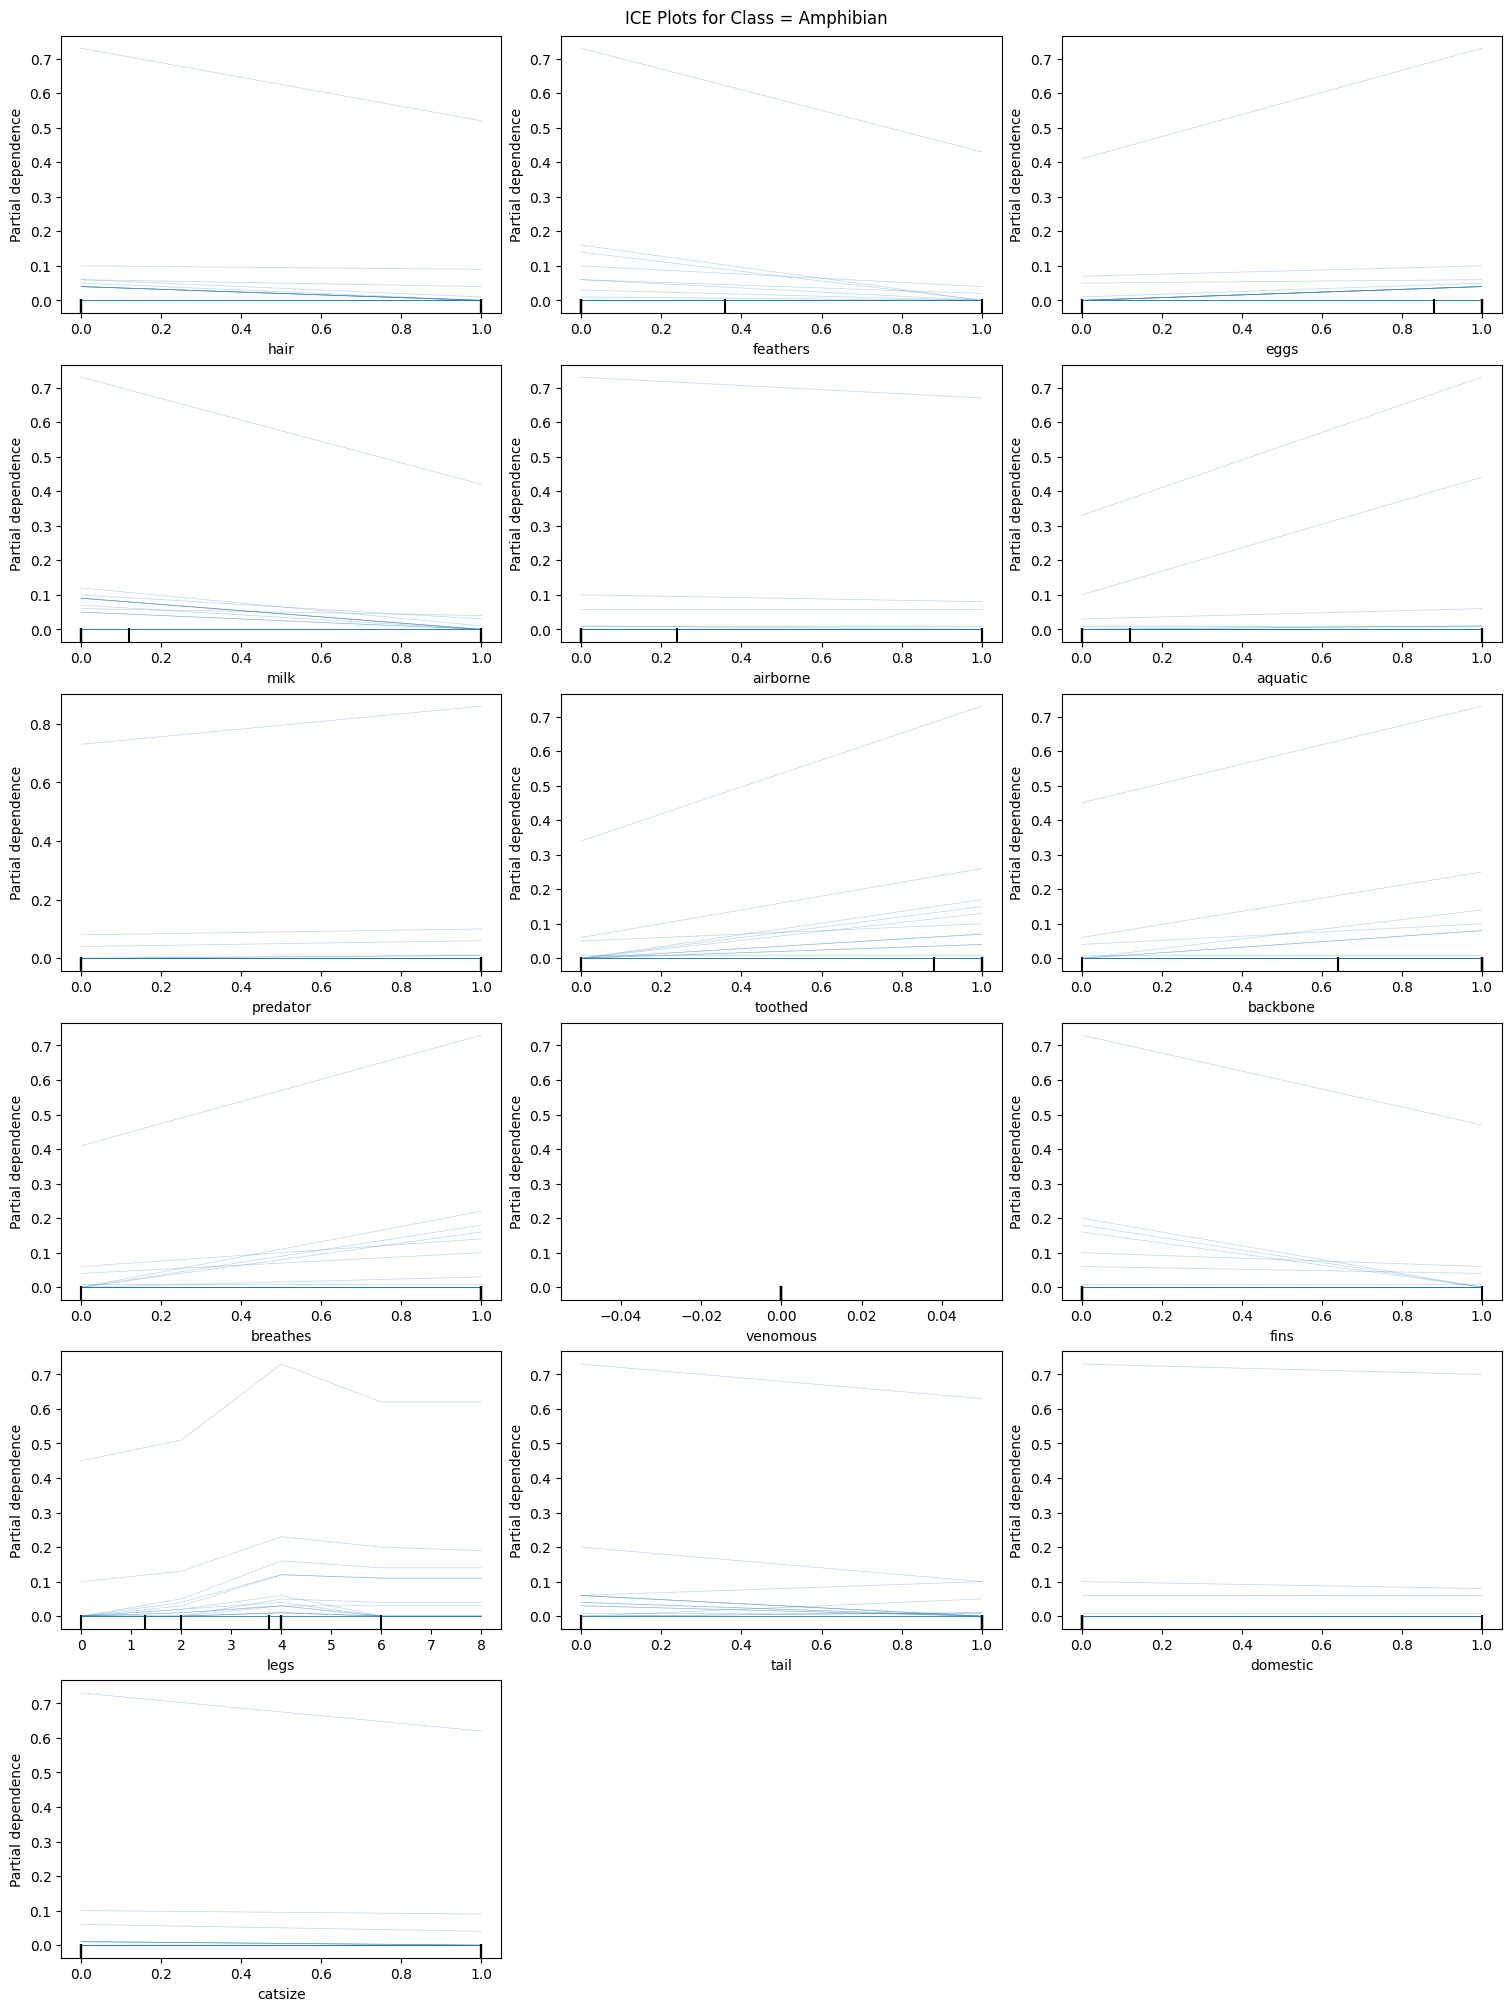

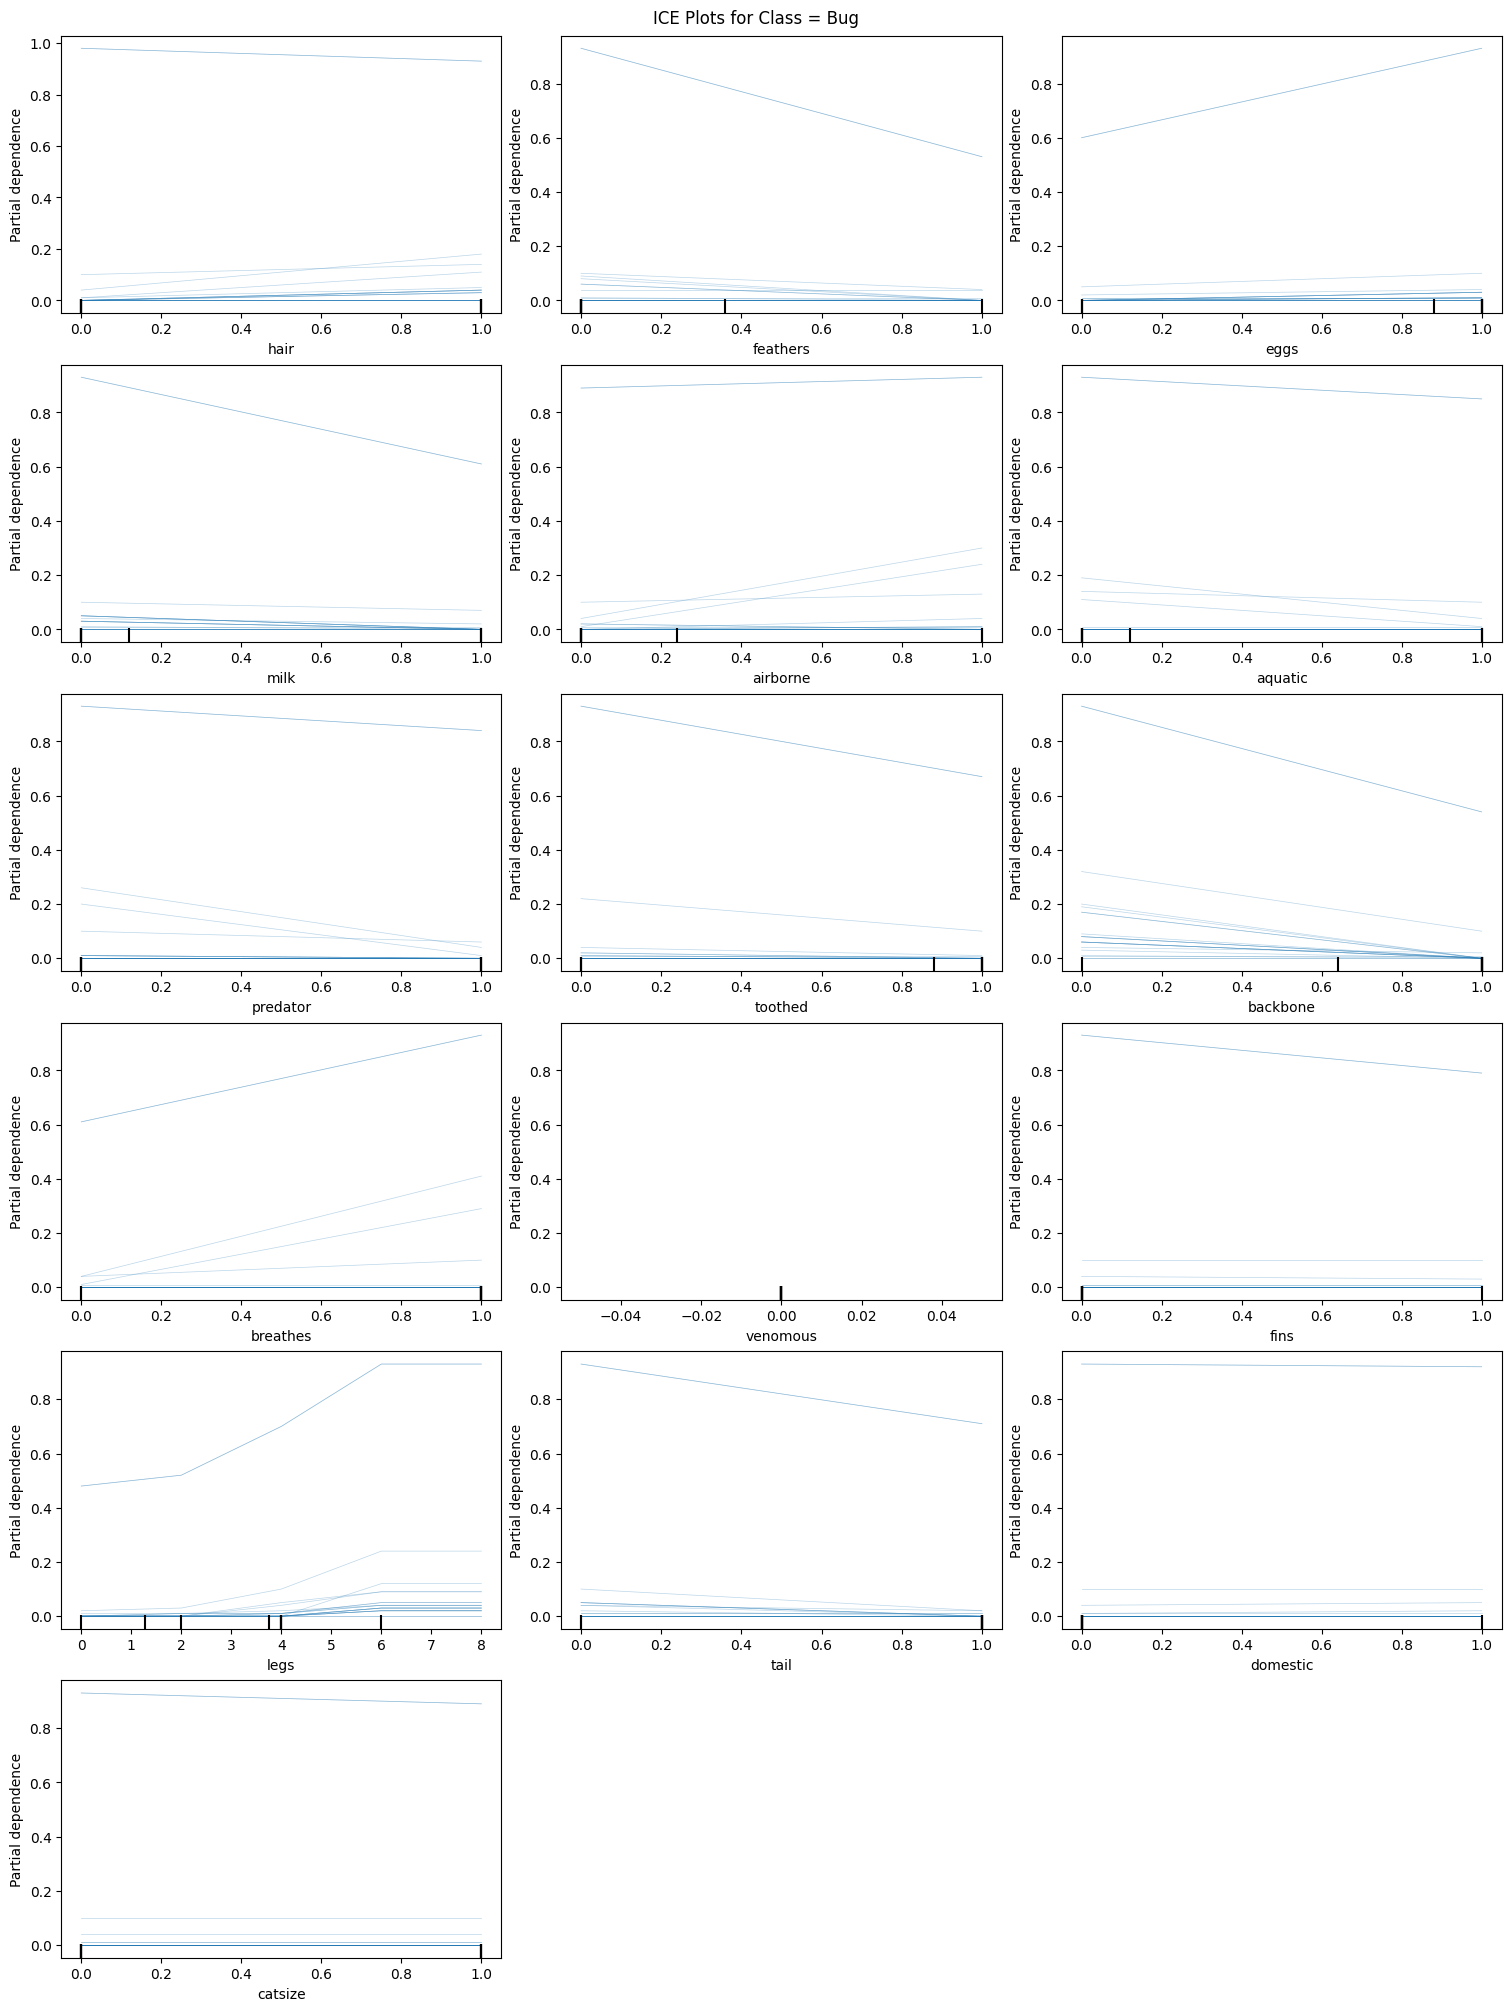

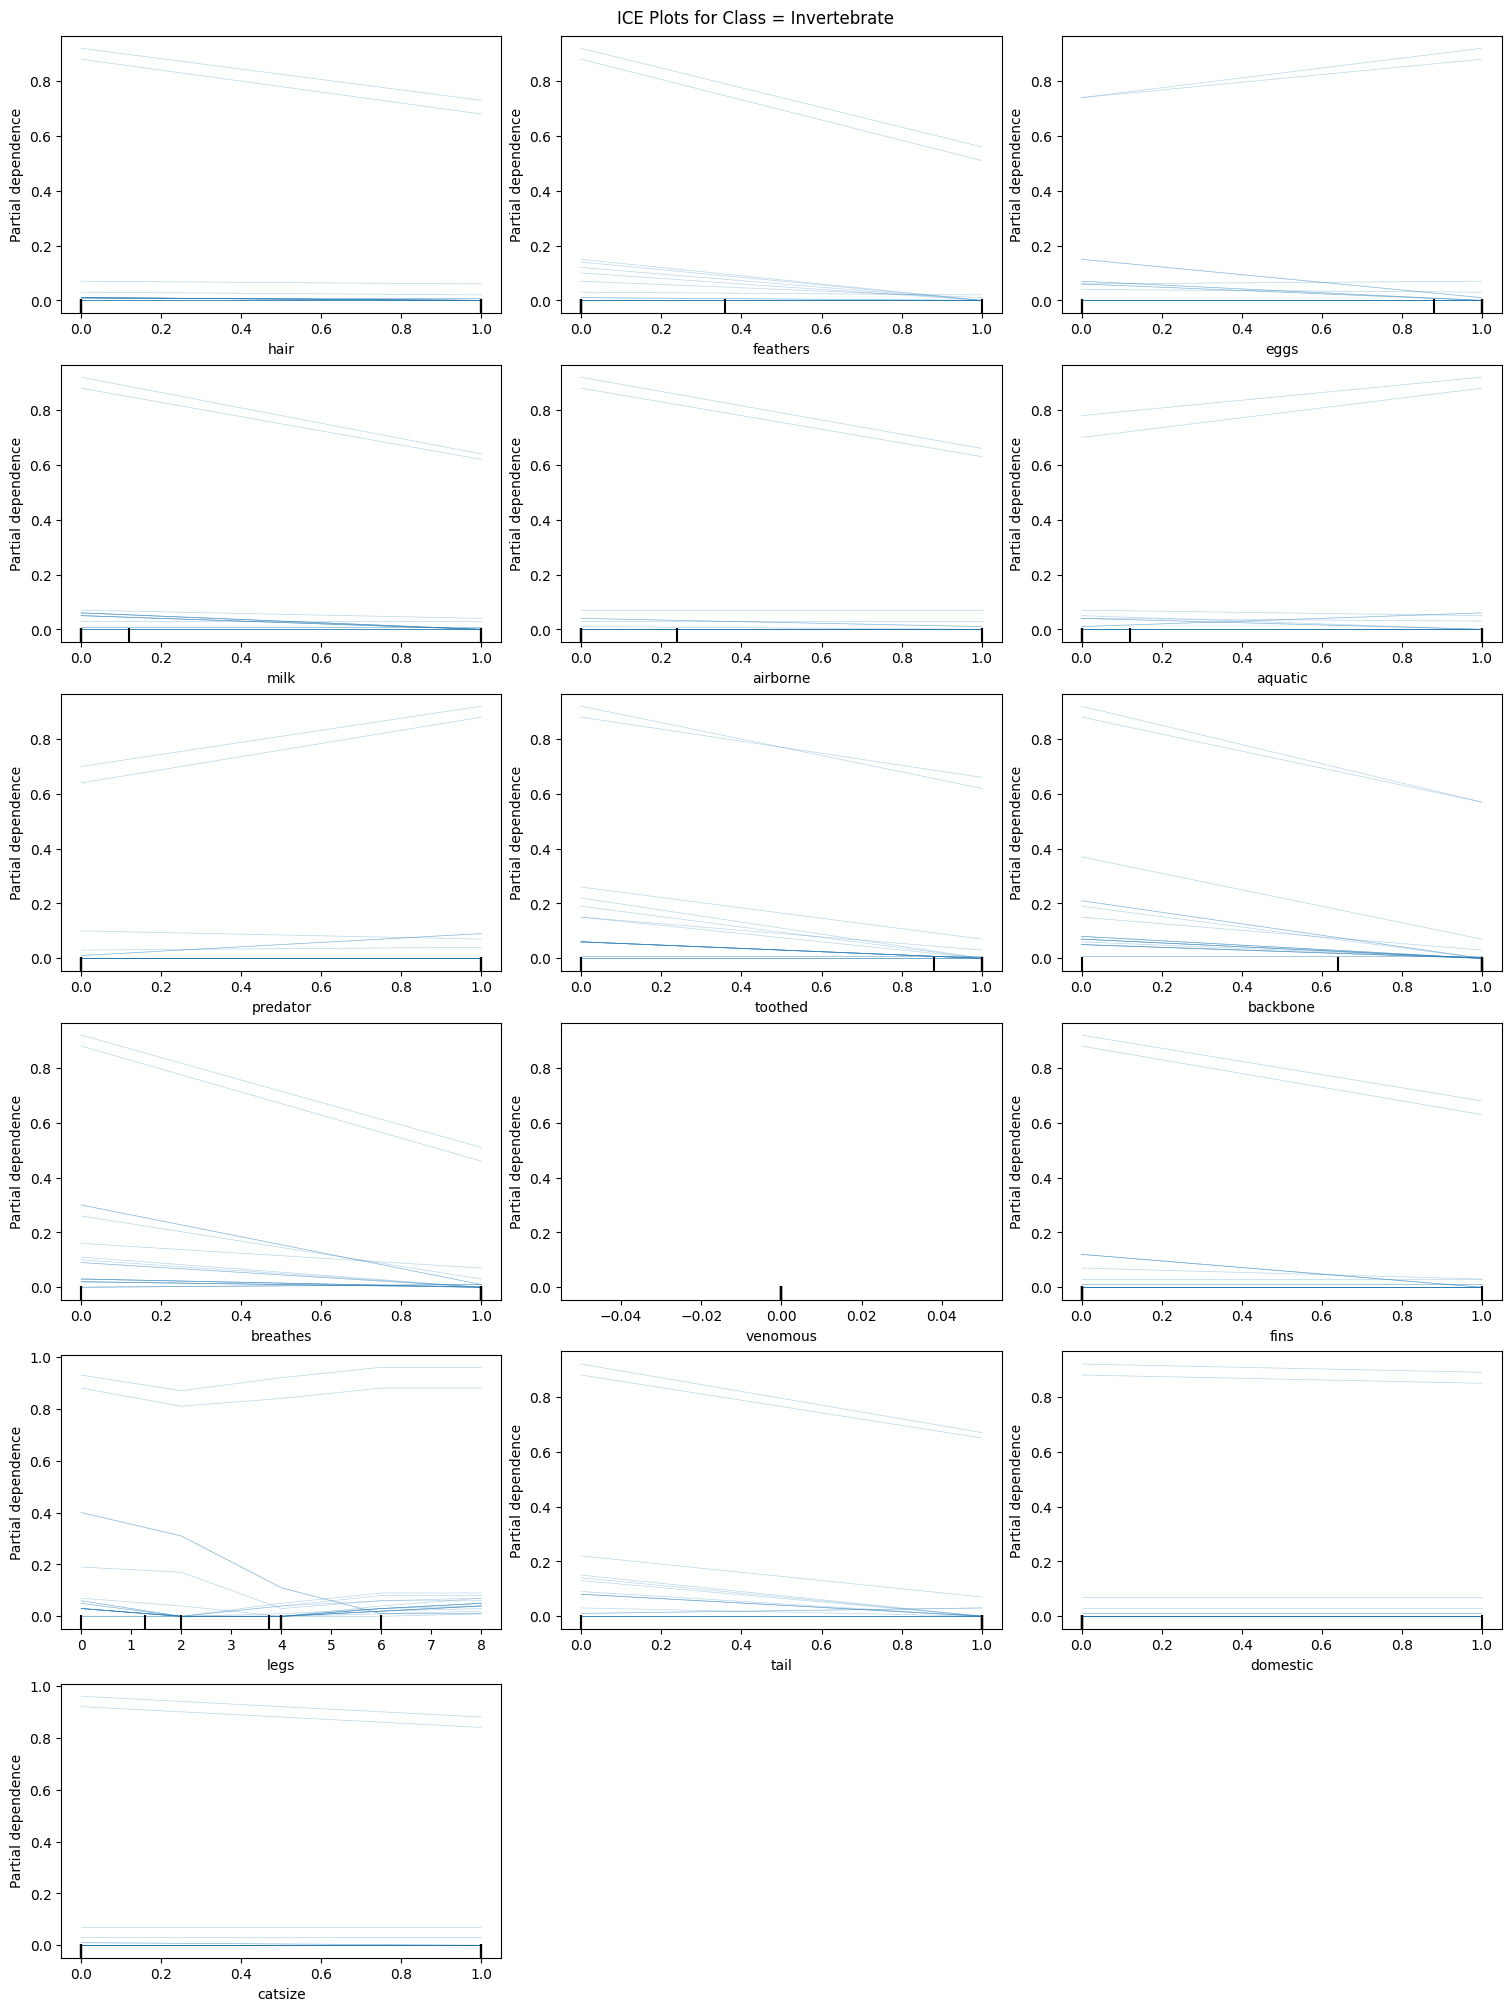

In [ ]:
# Create ICE plots for each feature against each class
for target_class in class_labels:
    fig, axes = plt.subplots( nrows=int(len(feature_names) / 3) + 1, ncols=3, figsize=(15, 20), constrained_layout=True)
    axes = axes.flatten()

    for i, feature in enumerate(feature_names):
        PartialDependenceDisplay.from_estimator(model, X_test, [feature], kind="individual", target=target_class, ax=axes[i]) # Create ICE plot

    for j in range(len(feature_names), len(axes)): # Hide unused axes
        fig.delaxes(axes[j])

    fig.suptitle(f"ICE Plots for Class = {class_mapping[target_class]}")
    plt.show()

The ICE plots show more variation in feature changes than the PDP plots. These plots show that different classes respond differently to changes in the same feature. Some features are strongly linked, like having hair and producing milk or having legs and having a backbone, changing one feature can have very different effects depending on the animal's other traits. There is a wide distribution of lines in the plots meaning the model is learning from combinations of features rather than treating them separately which may cause overfitting or unreliable predictions for unusual animals (like the platypus).

### **ALE Plot**

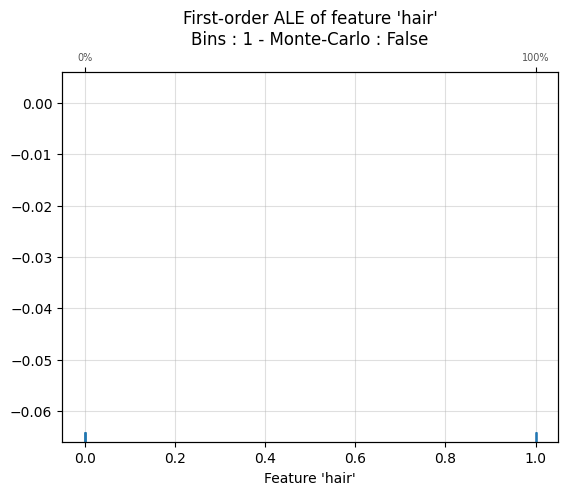

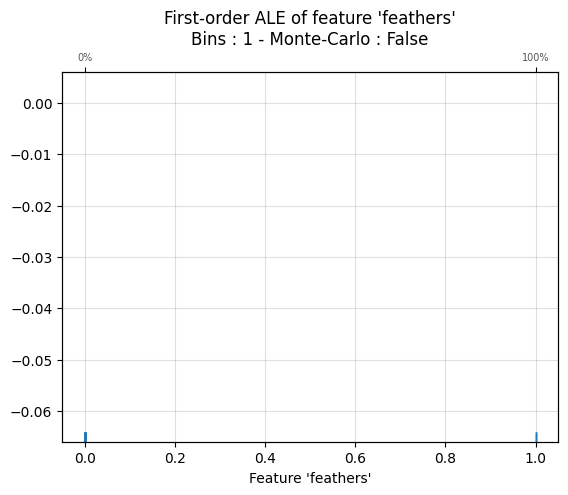

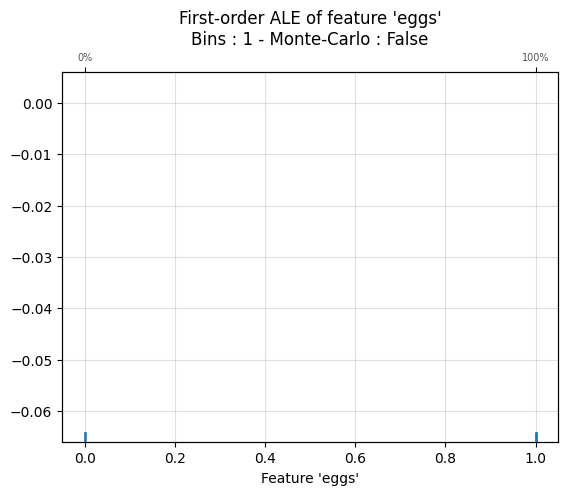

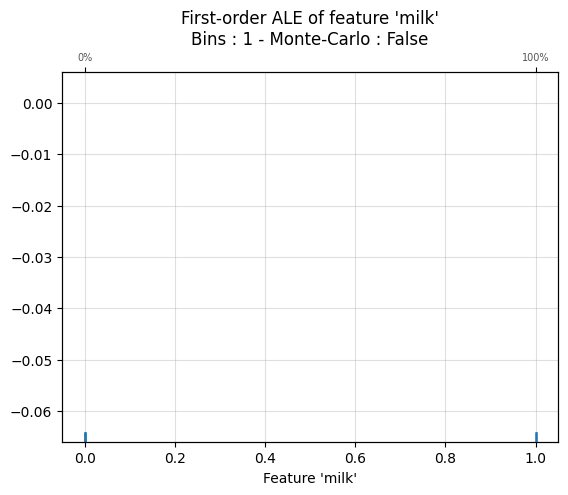

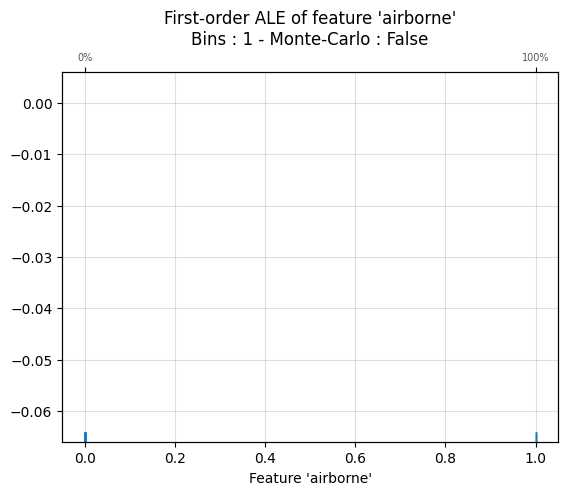

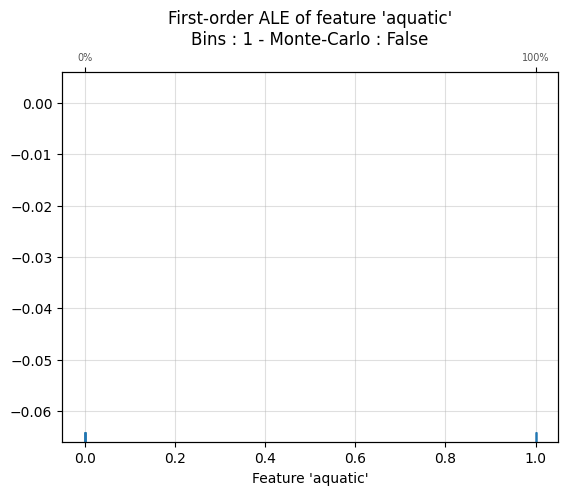

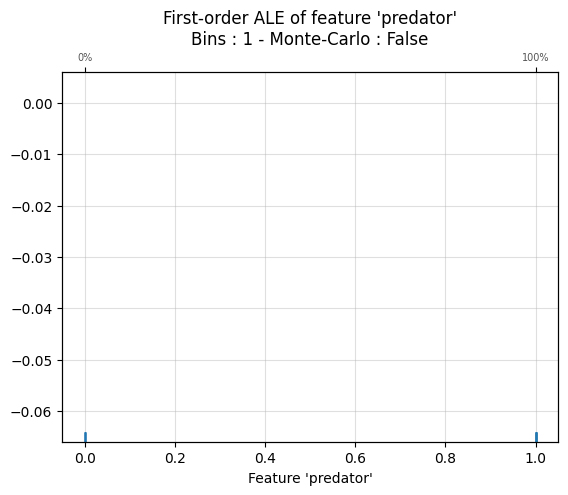

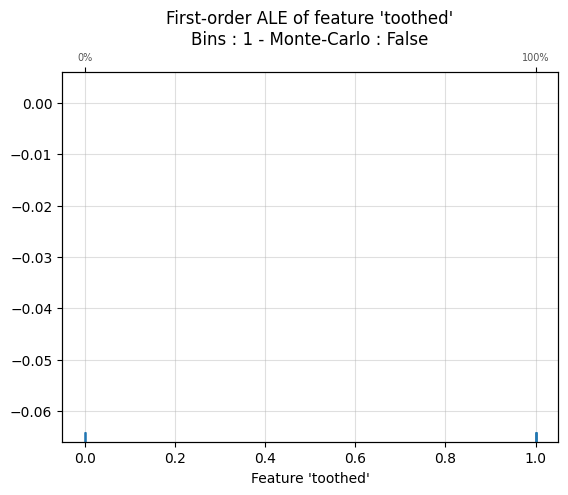

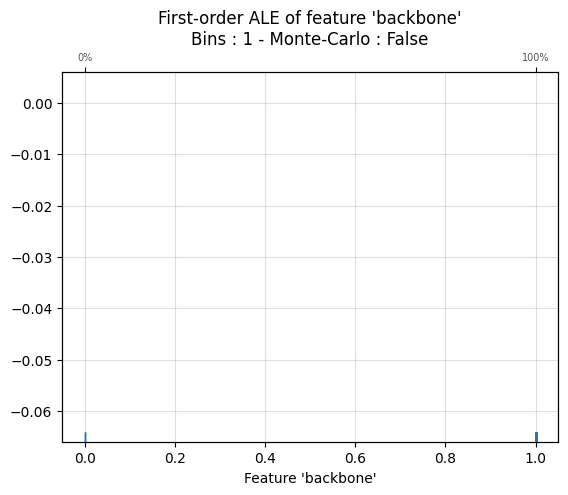

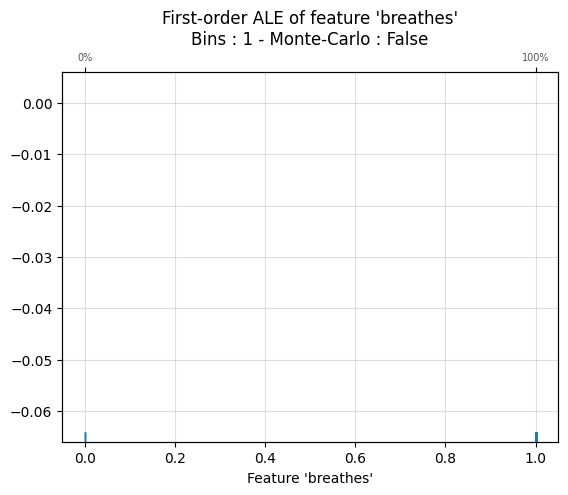

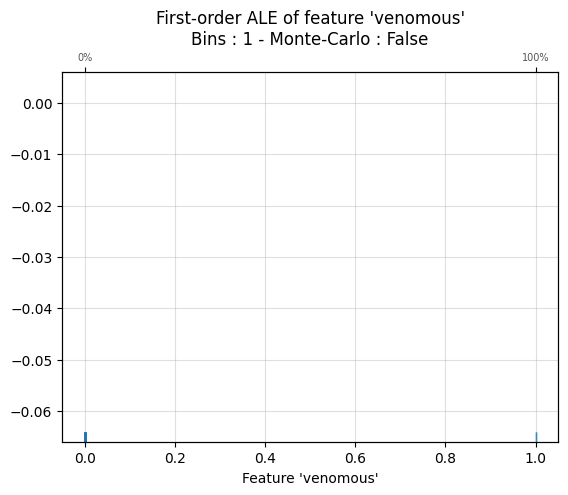

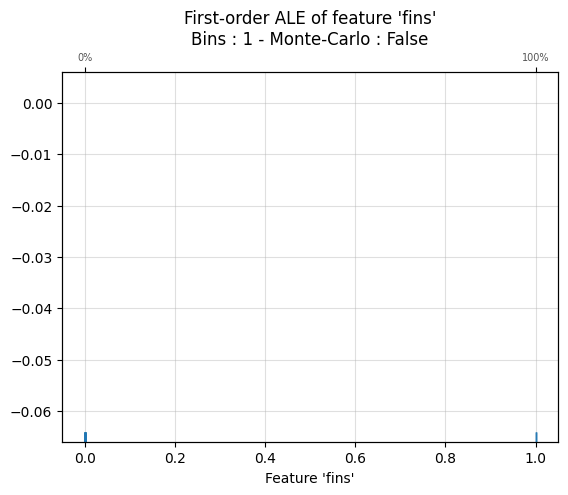

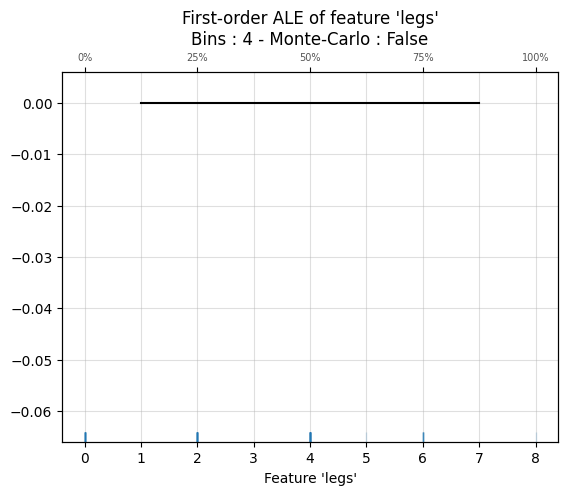

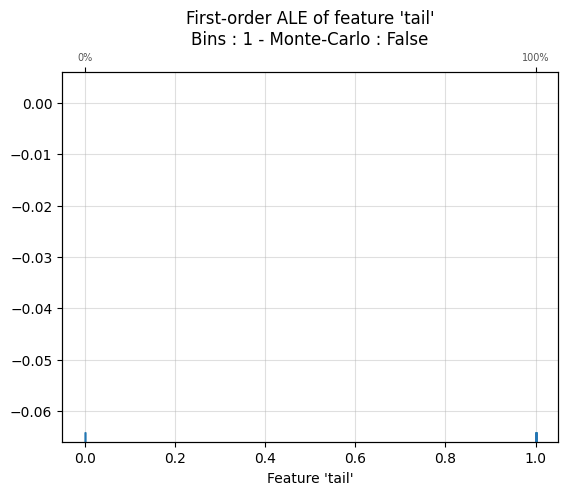

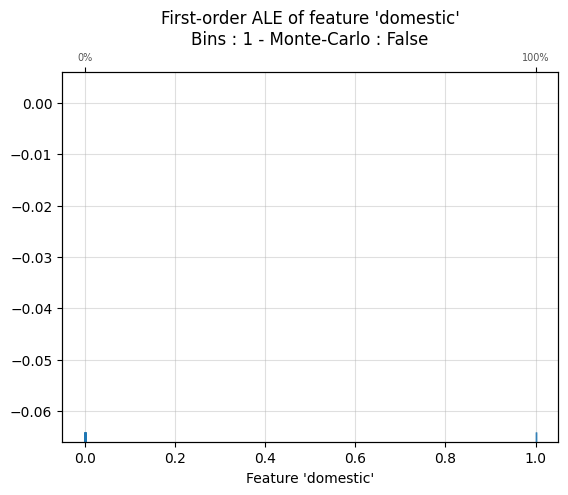

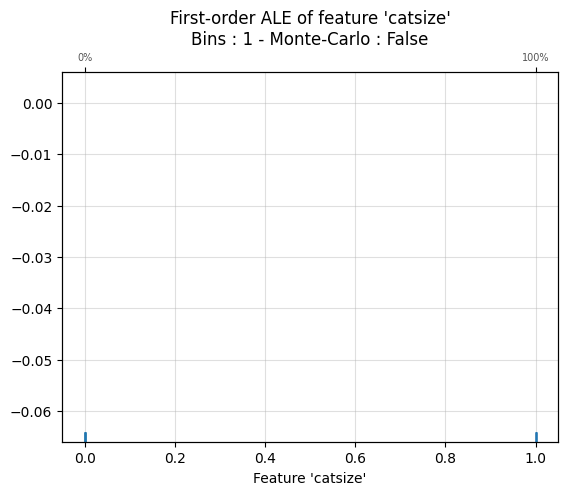

In [ ]:
numeric_features = [f for f in X_train.columns if X_train[f].nunique() > 1]

for feature in numeric_features:
    ale_plot(model, X_train, features=[feature], bins=10, monte_carlo=False)

    plt.show()

The ALE plots show fewer features than the previous plots because only a few features have sufficient variation to generate ALE plots. Most of the features in the dataset are binary which do no thave enough distinct values for ALE computation. The plot that shows the most variation is the legs plot because it is the only nulti-valued numeric variable in the dataset, with values ranging from 0 to 6+. The plot is horizontal which shows that number of legs have little to no independent effect on the class prediction, which means that the legs feature importance (displayed in the PDP plot) is due to its correlation with other features. Overall, because this dataset consists of primarily binary features, ALE plots are not the most descriptive plots to explain the model's reasoning.

### **Analysis**

The 3 plots give different insights into how the features affect the animal classification model. The PDP shows some features, like milk and hair or feathers and eggs, as having strong correlated effects on class predictions. The ICE plots showed that individual animals reacted differently to the same features within a class. The ALE plots showed that many features that previously seemed significant had almost no independent effect at all. Overall, this means that the model's accuracy comes mostly from correlated features working together rather than individual features. This makes the model good at predicting most typical animals but it struggles at predicting animals with unusual feature combinations.